# Must Run

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopy.distance
import seaborn as sns
import glob
import os
import scipy as sci
import scipy.signal as sig
import scipy.spatial as spa
import scipy.stats as stat
from collections import Counter
from IPython.display import Audio
import random
from matplotlib import rcParams
import math
wave = np.sin(2*np.pi*400*np.arange(10000*2)/10000)

ex = './Historical Data/%s.csv'
path = ex % 'LCM'
!wc -1 $psth

wc: illegal option -- 1
usage: wc [-clmw] [file ...]


# Bird

In [2]:
#upload pollen dataset as csv
pmm = pd.read_csv('./PollenandBird/minimalbirddata.csv')
pmm = pmm.set_index('tag-local-identifier')

### Function

In [3]:
def birddist(tagname):
    sixsixtyone = pd.DataFrame()
    for x in range(len(pmm.index)):
        if pmm.index[x] == tagname:
            sixsixtyone = pd.concat([sixsixtyone, pmm.iloc[x]], axis = 1)
    sixsixtyone = sixsixtyone.T
    sixsixtyone['Date'] = pd.to_datetime(sixsixtyone['Date'])
    sixsixtyone = sixsixtyone.set_index('Date')
    sixsixtyone['location-longint'] = sixsixtyone['location-long'].astype(str).astype(float)
    sixsixtyone['location-latint'] = sixsixtyone['location-lat'].astype(str).astype(float)

    #group 659
    groupedsixsixtyone = sixsixtyone.groupby('Date')['location-longint','location-latint'].mean()
    groupedsixsixtyone['MeanCoordinates']  = list(zip(groupedsixsixtyone['location-latint'], groupedsixsixtyone['location-longint']))

    #Make a plot for distance per day
    distperdayarr = np.empty(len(groupedsixsixtyone))
    for x in range(len(groupedsixsixtyone)):
        coord1 = groupedsixsixtyone['MeanCoordinates'].iloc[x]
        coord2 = groupedsixsixtyone['MeanCoordinates'].iloc[x-1]
        distperdayarr[x] = geopy.distance.distance(coord1, coord2).km
    distperday = pd.DataFrame(distperdayarr)
    distperday = distperday.set_index(groupedsixsixtyone.index)
    fig, (ax1, ax2) = plt.subplots(2)
    figure = ax1.plot(distperday)
    
    #PSD of distance per day with an NFFT of 2^8, with plt.psd() detrending the data
    a, b = ax2.psd(distperday, Fs = 1, scale_by_freq = False, NFFT = 2**8, detrend = 'linear')
    distperdaydata = a
    distperdayindex = b
    zdistperdayinmeeting = stat.zscore(distperdaydata)
    return distperday, figure, a, b;

<ipython-input-3-7037d8010a9c>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  groupedsixsixtyone = sixsixtyone.groupby('Date')['location-longint','location-latint'].mean()


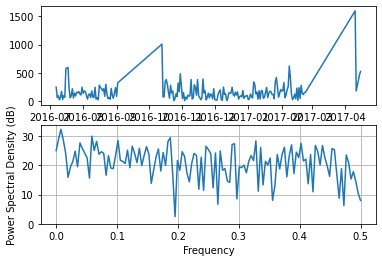

In [4]:
distperday, figure, a, b= birddist('Z660')

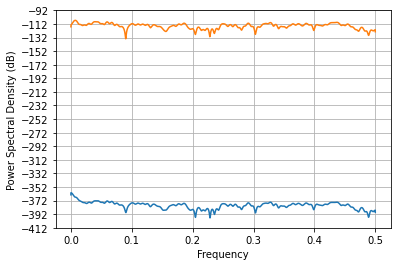

In [5]:
#Detrending distance per day with sig.detrend()
dtdistperday = sig.detrend(distperday)
dtdistperday = pd.DataFrame(dtdistperday)
dtadistperday,dtbdistperday = plt.psd(dtdistperday, Fs = 1, scale_by_freq = False, NFFT = 2**14 ) #in blue

#Z-scored data of dist per day with sig.detrend()
zdistperday = stat.zscore(dtdistperday)
zdistperday = pd.DataFrame(zdistperday)
zadistperday,zbdistperday = plt.psd(zdistperday, Fs = 1, scale_by_freq = False, NFFT = 2**14 )

# Pollen

In [6]:
pollen = pd.read_csv('./PollenandBird/pollen.csv', index_col = 'Date')
pollen = pollen.sort_index()
pollen = pollen['1998-01-01':'2018-12-31']
simple = pollen.set_index(np.array(range(0,6145)))

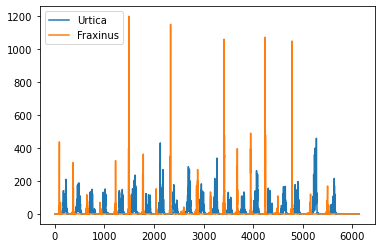

In [7]:
#plotting two very different pollen genuses
plt.plot(simple['Urtica'])
plt.plot(simple['Fraxinus'])
plt.legend(('Urtica','Fraxinus'), loc="upper left")

([<matplotlib.axis.XTick at 0x7fe266578c10>,
 [Text(0, 0, '1992'), Text(7784, 0, '2018')])

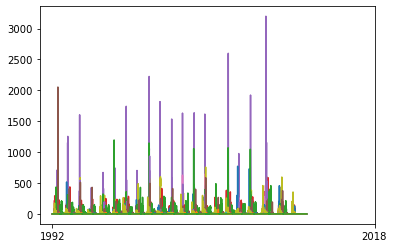

In [8]:
#Pollen Graph
plt.plot(simple)
plt.xticks((0,7784), (1992,2018))

In [9]:
#Pollen Mean
pollenmean=pollen.mean(axis=(1))
pollenmean

Date
1998-01-01    0.000000
1998-01-02    0.000000
1998-01-03    0.000000
1998-01-04    0.000000
1998-01-05    0.000000
                ...   
2018-12-27    0.000000
2018-12-28    0.121212
2018-12-29    0.000000
2018-12-30    0.000000
2018-12-31    0.000000
Length: 6145, dtype: float64

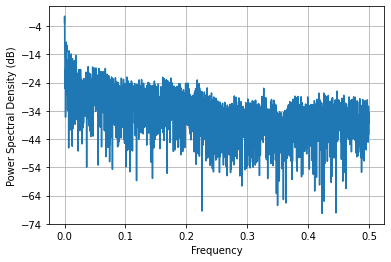

In [10]:
#PSD of pollen mean with an NFFT of 2^14
a, b = plt.psd(pollenmean, Fs = 1, scale_by_freq = False, NFFT = 2**14)
pollenmeandata = a
pollenmeanindex = b

### Detrended and Z-Score  Pollen

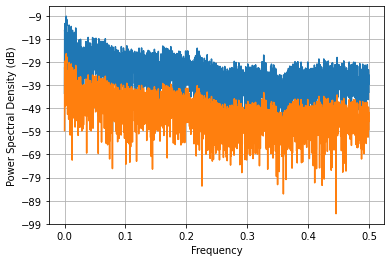

In [11]:
dtpollenmean = sig.detrend(pollenmean)
dtpollenmean = pd.DataFrame(dtpollenmean)
dtapollenmean,dtbpollenmean = plt.psd(dtpollenmean, Fs = 1, scale_by_freq = False, NFFT = 2**14 ) #in blue
zpollenmean = stat.zscore(dtpollenmean)
zpollenmean = pd.DataFrame(zpollenmean)
zapollenmean,zbpollenmean = plt.psd(zpollenmean, Fs = 1, scale_by_freq = False, NFFT = 2**14 ) #in orange

## All Pollen

In [12]:
urtica = simple['Urtica']
frax = simple['Fraxinus']
frax.index = pollen.index

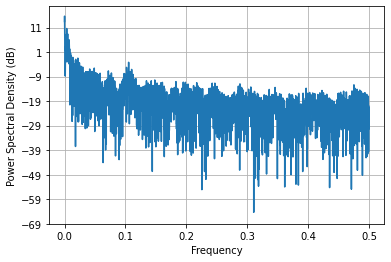

In [13]:
#PSD of Urtica
a, b = plt.psd(urtica, Fs = 1, scale_by_freq = False, NFFT = 2**14)
urticadata = a
urticaindex = b

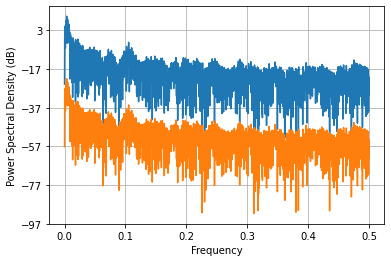

In [14]:
#Detrended Urtica
dturtica = sig.detrend(urtica)
dturtica = pd.DataFrame(dturtica)
dtaurtica,dtburtica = plt.psd(dturtica, Fs = 1, scale_by_freq = False, NFFT = 2**14 ) #in blue

#Z-scored Urtica
zurtica = stat.zscore(dturtica)
zurtica = pd.DataFrame(zurtica)
zaurtica,zburtica = plt.psd(zurtica, Fs = 1, scale_by_freq = False, NFFT = 2**14 ) #in orange

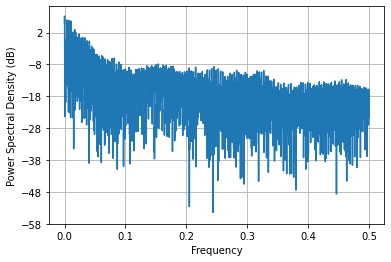

In [15]:
#PSD of frax
a, b = plt.psd(frax, Fs = 1, scale_by_freq = False, NFFT = 2**14)
fraxdata = a
fraxindex = b

In [16]:
frax

Date
1998-01-01    0
1998-01-02    0
1998-01-03    0
1998-01-04    0
1998-01-05    0
             ..
2018-12-27    0
2018-12-28    0
2018-12-29    0
2018-12-30    0
2018-12-31    0
Name: Fraxinus, Length: 6145, dtype: int64

write a function that accepts wideform data and spits out a vector of period and power, test on noaa and on neon, make an argument for LF or WF
write another function that makes a lineplot
and a heatmap

In [4]:
pHdata = pd.read_csv('/Users/athenaye/Desktop/Complete Data/localDissolvedOxygenSat.csv', index_col = 'startDateTime')
pHdata.index = pd.to_datetime(pHdata.index)
pHdata = pHdata.drop('Unnamed: 0', axis = 1)
pHdata
pHdata = pHdata[pHdata['variable'] == 'localDissolvedOxygenSat']
pHdata = pHdata.pivot(columns='siteID')[['value']]

pHdata.to_csv('/Users/athenaye/Desktop/localDissolvedOxygenSat.csv')

In [27]:
def toheatmap(filepath, variableindicator, officialname, nfft):
    masteramean = pd.DataFrame()
    for t in range(len(filepath)):
        try:
            pHdata = pd.read_csv(filepath[t], index_col = 'startDateTime')
            pHdata.index = pd.to_datetime(pHdata.index)
            pHdata = pHdata.drop('Unnamed: 0', axis = 1)
            pHdata
            pHdata = pHdata[pHdata['variable'] == variableindicator[t]]
            pHdata = pHdata.pivot(columns='siteID')[['value']]
            for x in range(len(pHdata.columns)):
                nonan = pHdata[pHdata.columns[x]]
                nonan = nonan.interpolate('time', limit_direction='both')
                a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**nfft)
                if x == 0:
                    acumulative = a
                    bcumulative = b
                else:
                    acumulative = np.vstack([acumulative, a])
                    bcumulative = np.vstack([bcumulative, b])
            aphmean = acumulative.mean(axis=(0))
            bphmean = bcumulative.mean(axis=(0))
            aphmean = pd.DataFrame(aphmean, index = bphmean)
            base = sci.interpolate.interp1d(1/aphmean.index[1:],aphmean.iloc[1:,0], kind = 'nearest')
            xvalues = np.linspace(1,nfft-1, num = 2**(nfft-1)+1, endpoint = True)
            xvalues = xvalues[::-1]
            xvalues = 2**xvalues
            interparray = base(xvalues)
            aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = [officialname[t]])
            aphmean = aphmean/aphmean.max()
            masteramean = pd.concat([masteramean, aphmean], axis = 1)
        except:
            avgoverall = pd.read_csv(filepath[t], index_col = 'date')
            avgoverall.index = pd.to_datetime(avgoverall.index)
            avgoverallsamp = avgoverall.iloc[:,0:50]
            for x in range(len(avgoverallsamp.columns)):
                nonan = avgoverallsamp[avgoverallsamp.columns[x]]
                nonan = nonan.interpolate('linear', limit_direction = 'both')
                a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**nfft, detrend = 'linear')
                if x == 0:
                    ameancumulative = a
                    bmeancumulative = b
                else:
                    ameancumulative = np.vstack([ameancumulative, a])
                    bmeancumulative = np.vstack([bmeancumulative, b])
            amean = ameancumulative.mean(axis=(0))
            bmean = bmeancumulative.mean(axis=(0))
            amean = pd.DataFrame(amean, index = bmean)
            base = sci.interpolate.interp1d(1/amean.index[1:],amean.iloc[1:,0], kind = 'nearest')
            xvalues = np.linspace(1,nfft-1, num = 2**(nfft-1)+1, endpoint = True)
            xvalues = xvalues[::-1]
            xvalues = 2**xvalues
            interparray = base(xvalues)
            a14mean = pd.DataFrame(interparray, index = 1/bmean, columns = [officialname[t]])
            a14mean = a14mean/a14mean.max()
            masteramean = pd.concat([masteramean, a14mean], axis = 1)
    yvalues = np.array(range(0,2**(nfft-1)+1))
    xtickmarks = [2, 4,8,16,32,64,128,256,365, 365*2, 365*4, 365*8, 365*16, 8192]

    x = xvalues
    y = yvalues
    f = sci.interpolate.interp1d(x, y)
    xtickmarks = xtickmarks[0:nfft]
    xnew = xtickmarks #Starting period, ending period, interval of jump
    ynew = f(xnew) # use interpolation function returned by `interp1d`
    rcParams['figure.figsize'] = 11.7,8.27
    s = sns.heatmap(np.log(masteramean.T), cbar_kws={'label': 'Log of Power Spectral Density'})
    s.set_title('Power Spectral Density')
    #s.set_xscale("log", base = 2)
    s.set_xlabel('Period (days)') 
    locs, labels = plt.xticks()
    newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d']
    plt.xticks(ynew,newlabel)

<ipython-input-27-63d3d0c2a6d0>:29: RuntimeWarning: divide by zero encountered in true_divide
  aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = [officialname[t]])
<ipython-input-27-63d3d0c2a6d0>:29: RuntimeWarning: divide by zero encountered in true_divide
  aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = [officialname[t]])
<ipython-input-27-63d3d0c2a6d0>:29: RuntimeWarning: divide by zero encountered in true_divide
  aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = [officialname[t]])
<ipython-input-27-63d3d0c2a6d0>:29: RuntimeWarning: divide by zero encountered in true_divide
  aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = [officialname[t]])
<ipython-input-27-63d3d0c2a6d0>:29: RuntimeWarning: divide by zero encountered in true_divide
  aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = [officialname[t]])
<ipython-input-27-63d3d0c2a6d0>:29: RuntimeWarning: divide by zero encountered in true_divide
  aphm

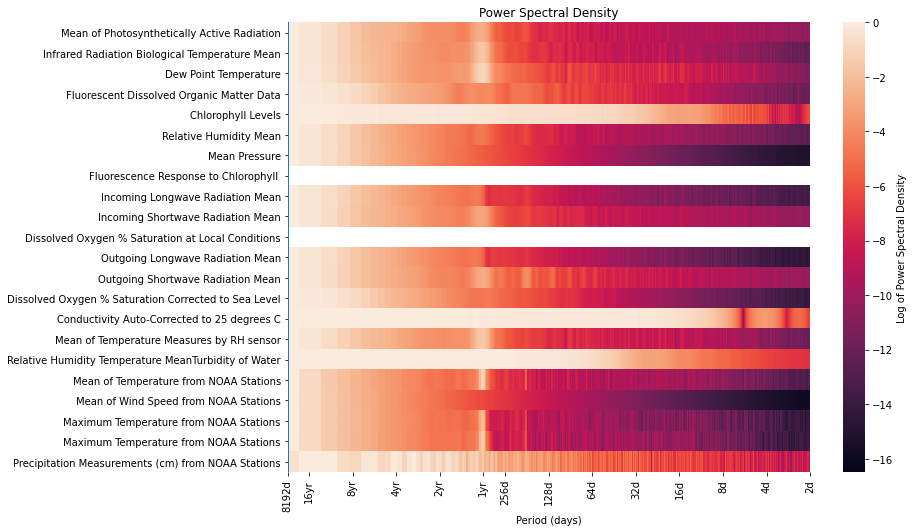

In [29]:
toheatmap([
    '/Users/athenaye/Desktop/Complete Data/PARMean.csv',
           '/Users/athenaye/Desktop/Complete Data/bioTempMean.csv',
           '/Users/athenaye/Desktop/Complete Data/dewTempMean.csv',
           '/Users/athenaye/Desktop/Complete Data/fDOM.csv',
           '/Users/athenaye/Desktop/Complete Data/chlorophyll.csv',
           '/Users/athenaye/Desktop/Complete Data/RHMean.csv',
           '/Users/athenaye/Desktop/Complete Data/staPresMean.csv',
           '/Users/athenaye/Desktop/Complete Data/chlaRelativeFluorescence.csv',
           '/Users/athenaye/Desktop/Complete Data/inLWMean.csv',
           '/Users/athenaye/Desktop/Complete Data/inSWMean.csv',
           '/Users/athenaye/Desktop/Complete Data/localDissolvedOxygenSat.csv',
           '/Users/athenaye/Desktop/Complete Data/outLWMean.csv',
           '/Users/athenaye/Desktop/Complete Data/outSWMean.csv',
           '/Users/athenaye/Desktop/Complete Data/seaLevelDissolvedOxygenSat.csv',
           '/Users/athenaye/Desktop/Complete Data/specificConductance.csv',
           '/Users/athenaye/Desktop/Complete Data/tempRHMean.csv',
            '/Users/athenaye/Desktop/Complete Data/turbidity.csv',
           './PollenandBird/avgoverall.csv',
           './PollenandBird/awndoverall.csv',
           './PollenandBird/maxoverall.csv',
           './PollenandBird/minoverall.csv',
           './PollenandBird/prcpoverall.csv'],
          ['PARMean','bioTempMean', 'dewTempMean', 'fDOM','chlorophyll','RHMean','staPresMean',
          'chlaRelativeFluorescence', 'inLWMean', 'inSWMean', 'localDissolvedOxygenSat', 'outLWMean', 'outSWMean', 
           'seaLevelDissolvedOxygenSat', 'specificConductance', 'tempRHMean', 
              'turbidity',
           'avgoverall', 'awndoverall', 'maxoverall', 
          'minoverall', 'prcpoverall'],
            ['Mean of Photosynthetically Active Radiation', 'Infrared Radiation Biological Temperature Mean', 'Dew Point Temperature', 'Fluorescent Dissolved Organic Matter Data', 'Chlorophyll Levels','Relative Humidity Mean',
             'Mean Pressure', 'Fluorescence Response to Chlorophyll ', 'Incoming Longwave Radiation Mean', 'Incoming Shortwave Radiation Mean', 'Dissolved Oxygen % Saturation at Local Conditions', 'Outgoing Longwave Radiation Mean', 
             'Outgoing Shortwave Radiation Mean', 'Dissolved Oxygen % Saturation Corrected to Sea Level', 'Conductivity Auto-Corrected to 25 degrees C', 'Mean of Temperature Measures by RH sensor', 'Relative Humidity Temperature Mean'
              'Turbidity of Water',
           'Mean of Temperature from NOAA Stations', 'Mean of Wind Speed from NOAA Stations', 'Maximum Temperature from NOAA Stations', 
          'Maximum Temperature from NOAA Stations', 'Precipitation Measurements (cm) from NOAA Stations'],14)

              chlaRelativeFluorescence
inf                           1.000000
1.638400e+04                  1.000000
8.192000e+03                  1.000000
5.461333e+03                  1.000000
4.096000e+03                  1.000000
...                                ...
2.000977e+00                  0.011193
2.000733e+00                  0.019516
2.000488e+00                  0.042376
2.000244e+00                  0.210147
2.000000e+00                  0.487679

[8193 rows x 1 columns]


<ipython-input-49-d44440a0b150>:26: RuntimeWarning: divide by zero encountered in true_divide
  aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = ['chlaRelativeFluorescence'])


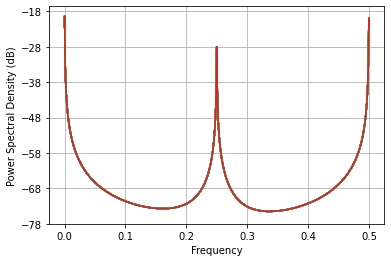

In [49]:
pHdata = pd.read_csv('/Users/athenaye/Desktop/Complete Data/chlaRelativeFluorescence.csv', index_col = 'startDateTime')
pHdata.index = pd.to_datetime(pHdata.index)
pHdata = pHdata.drop('Unnamed: 0', axis = 1)
pHdata
pHdata = pHdata[pHdata['variable'] == 'chlaRelativeFluorescence']
pHdata = pHdata.pivot(columns='siteID')[['value']]
for x in range(len(pHdata.columns)):
    nonan = pHdata.iloc[:, [1,10,27,30]]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14)
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
aphmean = acumulative.mean(axis=(0))
bphmean = bcumulative.mean(axis=(0))
aphmean = pd.DataFrame(aphmean, index = bphmean)
base = sci.interpolate.interp1d(1/aphmean.index[1:],aphmean.iloc[1:,0], kind = 'nearest')
#base = aphmean
xvalues = np.linspace(1,13, num = 2**13+1, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
interparray = base(xvalues)
aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = ['chlaRelativeFluorescence'])
blahblah = aphmean/aphmean.max()
print(blahblah)

In [ ]:
aphmean


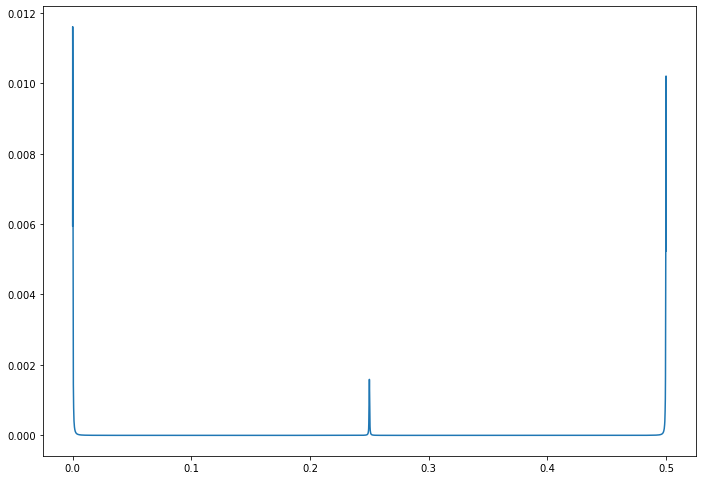

In [91]:
plt.plot(aphmean)

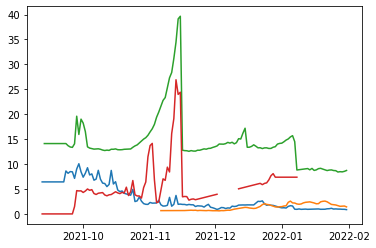

In [61]:
pHdata = pd.read_csv('/Users/athenaye/Desktop/Complete Data/chlaRelativeFluorescence.csv', index_col = 'startDateTime')
pHdata.index = pd.to_datetime(pHdata.index)
pHdata = pHdata.drop('Unnamed: 0', axis = 1)
pHdata
pHdata = pHdata[pHdata['variable'] == 'chlaRelativeFluorescence']
pHdata = pHdata.pivot(columns='siteID')[['value']]
for x in range(len(pHdata.columns)):
    nonan = pHdata.iloc[:, [1,10,27,30]]
    nonan = nonan.interpolate('time', limit_direction='both', limit = 10)
    #a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14)
plt.plot(nonan)

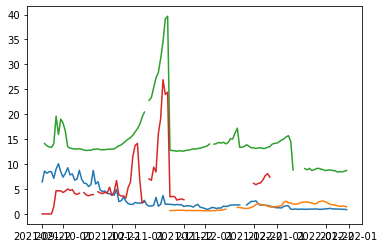

In [59]:
pHdata = pd.read_csv('/Users/athenaye/Desktop/Complete Data/chlaRelativeFluorescence.csv', index_col = 'startDateTime')
pHdata.index = pd.to_datetime(pHdata.index)
pHdata = pHdata.drop('Unnamed: 0', axis = 1)
pHdata
pHdata = pHdata[pHdata['variable'] == 'chlaRelativeFluorescence']
pHdata = pHdata.pivot(columns='siteID')[['value']]
for x in range(len(pHdata.columns)):
    nonan = pHdata.iloc[:, [1,10,27,30]]
    #nonan = nonan.interpolate('time', limit_direction='both')
    #a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14)
plt.plot(nonan)
indexofnan = nonan.isna().index
indexofnan = indexofnan.to_list()
#     a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14)
#     if x == 0:
#         acumulative = a
#         bcumulative = b
#     else:
#         acumulative = np.vstack([acumulative, a])
#         bcumulative = np.vstack([bcumulative, b])
# aphmean = acumulative.mean(axis=(0))
# bphmean = bcumulative.mean(axis=(0))
# aphmean = pd.DataFrame(aphmean, index = bphmean)
# print(aphmean)
# base = sci.interpolate.interp1d(1/aphmean.index[1:],aphmean.iloc[1:,0], kind = 'nearest')
# #base = aphmean
# xvalues = np.linspace(1,13, num = 2**13+1, endpoint = True)
# xvalues = xvalues[::-1]
# xvalues = 2**xvalues
# interparray = base(xvalues)
# aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = ['chlaRelativeFluorescence'])
# blahblah = aphmean/aphmean.max()
# print(blahblah)

In [38]:
indexofnan

[Timestamp('2016-03-04 00:00:00'),
 Timestamp('2016-03-05 00:00:00'),
 Timestamp('2016-03-06 00:00:00'),
 Timestamp('2016-03-07 00:00:00'),
 Timestamp('2016-03-08 00:00:00'),
 Timestamp('2016-03-09 00:00:00'),
 Timestamp('2016-03-10 00:00:00'),
 Timestamp('2016-03-11 00:00:00'),
 Timestamp('2016-03-12 00:00:00'),
 Timestamp('2016-03-13 00:00:00'),
 Timestamp('2016-03-14 00:00:00'),
 Timestamp('2016-03-15 00:00:00'),
 Timestamp('2016-03-16 00:00:00'),
 Timestamp('2016-03-17 00:00:00'),
 Timestamp('2016-03-18 00:00:00'),
 Timestamp('2016-03-19 00:00:00'),
 Timestamp('2016-03-20 00:00:00'),
 Timestamp('2016-03-21 00:00:00'),
 Timestamp('2016-03-22 00:00:00'),
 Timestamp('2016-03-23 00:00:00'),
 Timestamp('2016-03-24 00:00:00'),
 Timestamp('2016-03-25 00:00:00'),
 Timestamp('2016-03-26 00:00:00'),
 Timestamp('2016-03-27 00:00:00'),
 Timestamp('2016-03-28 00:00:00'),
 Timestamp('2016-03-29 00:00:00'),
 Timestamp('2016-03-30 00:00:00'),
 Timestamp('2016-03-31 00:00:00'),
 Timestamp('2016-04-

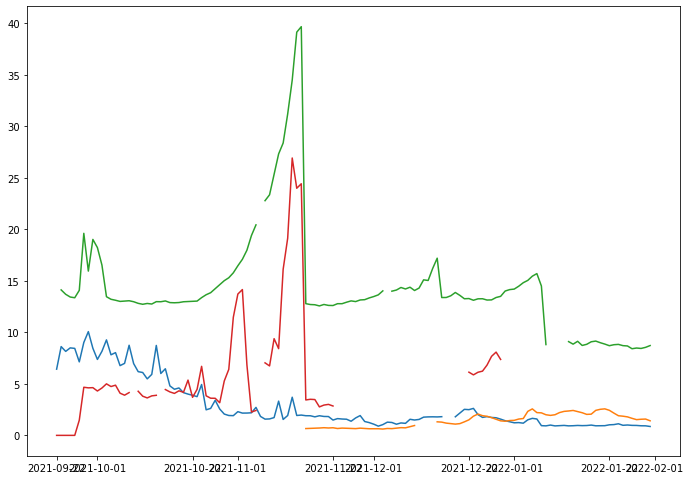

In [94]:
plt.plot(pHdata.iloc[:, [1,10,27,30]])
# manually switch to pandas interpolate, cap the # of days
# Find the program with every chunk between 10 day break
# All of functions to external file, new repository, GitHub project
# have functions that GitHub loads are the ones on google drive
# add folder in GH that has all the names of the ones in the Drive

In [56]:
pHdata.iloc[:, 30:34]

value               
siteID         TOMB TOOK WALK WLOU
startDateTime                     
2016-03-04      NaN  NaN  NaN  NaN
2016-03-05      NaN  NaN  NaN  NaN
2016-03-06      NaN  NaN  NaN  NaN
2016-03-07      NaN  NaN  NaN  NaN
2016-03-08      NaN  NaN  NaN  NaN
...             ...  ...  ...  ...
2022-01-27      NaN  NaN  NaN  NaN
2022-01-28      NaN  NaN  NaN  NaN
2022-01-29      NaN  NaN  NaN  NaN
2022-01-30      NaN  NaN  NaN  NaN
2022-01-31      NaN  NaN  NaN  NaN

[2160 rows x 4 columns]

([<matplotlib.axis.XTick at 0x7fc667d480a0>,
 [Text(8192.0, 0, '2d'),
  Text(7509.333446156619, 0, '4d'),
  Text(6826.666779477225, 0, '8d'),
  Text(6144.0, 0, '16d'),
  Text(5461.333446156619, 0, '32d'),
  Text(4778.666779477225, 0, '64d'),
  Text(4096.0, 0, '128d'),
  Text(3413.3334461566187, 0, '256d'),
  Text(3063.9768665044767, 0, '1yr'),
  Text(2381.3102969966953, 0, '2yr'),
  Text(1698.6436381508265, 0, '4yr'),
  Text(1015.9768665044764, 0, '8yr'),
  Text(333.31029699669557, 0, '16yr'),
  Text(0.0, 0, '8192d')])

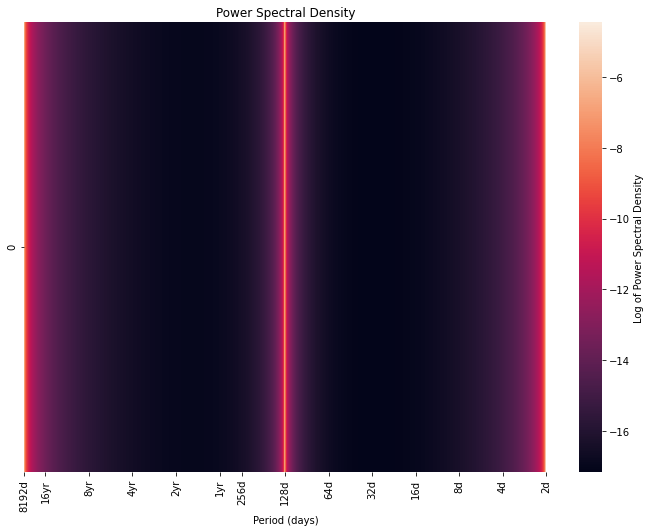

In [92]:
yvalues = np.array(range(0,2**(14-1)+1))
xtickmarks = [2, 4,8,16,32,64,128,256,365, 365*2, 365*4, 365*8, 365*16, 8192]

x = xvalues
y = yvalues
f = sci.interpolate.interp1d(x, y)
xtickmarks = xtickmarks[0:14]
xnew = xtickmarks #Starting period, ending period, interval of jump
ynew = f(xnew) # use interpolation function returned by `interp1d`
rcParams['figure.figsize'] = 11.7,8.27
s = sns.heatmap(np.log(aphmean.T), cbar_kws={'label': 'Log of Power Spectral Density'})
s.set_title('Power Spectral Density')
#s.set_xscale("log", base = 2)
s.set_xlabel('Period (days)') 
locs, labels = plt.xticks()
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d']
plt.xticks(ynew,newlabel)

              chlaRelativeFluorescence
inf                           1.000000
1.638400e+04                  1.000000
8.192000e+03                  1.000000
5.461333e+03                  1.000000
4.096000e+03                  1.000000
...                                ...
2.000977e+00                  0.011193
2.000733e+00                  0.019516
2.000488e+00                  0.042376
2.000244e+00                  0.210147
2.000000e+00                  0.487679

[8193 rows x 1 columns]


<ipython-input-79-b94e1913bfaf>:25: RuntimeWarning: divide by zero encountered in true_divide
  aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = ['chlaRelativeFluorescence'])


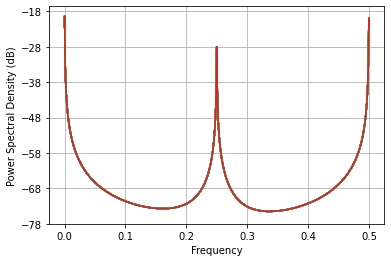

In [79]:
pHdata = pd.read_csv('/Users/athenaye/Desktop/Complete Data/chlaRelativeFluorescence.csv', index_col = 'startDateTime')
pHdata.index = pd.to_datetime(pHdata.index)
pHdata = pHdata.drop('Unnamed: 0', axis = 1)
pHdata
pHdata = pHdata[pHdata['variable'] == 'chlaRelativeFluorescence']
pHdata = pHdata.pivot(columns='siteID')[['value']]
for x in range(len(pHdata.columns)):
    nonan = pHdata.iloc[:, [1,10,27,30]]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14)
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
aphmean = acumulative.mean(axis=(0))
bphmean = bcumulative.mean(axis=(0))
aphmean = pd.DataFrame(aphmean, index = bphmean)
base = sci.interpolate.interp1d(1/aphmean.index[1:],aphmean.iloc[1:,0], kind = 'nearest')
xvalues = np.linspace(1,13, num = 2**13+1, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
interparray = base(xvalues)
aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = ['chlaRelativeFluorescence'])
blahblah = aphmean/aphmean.max()
print(blahblah)

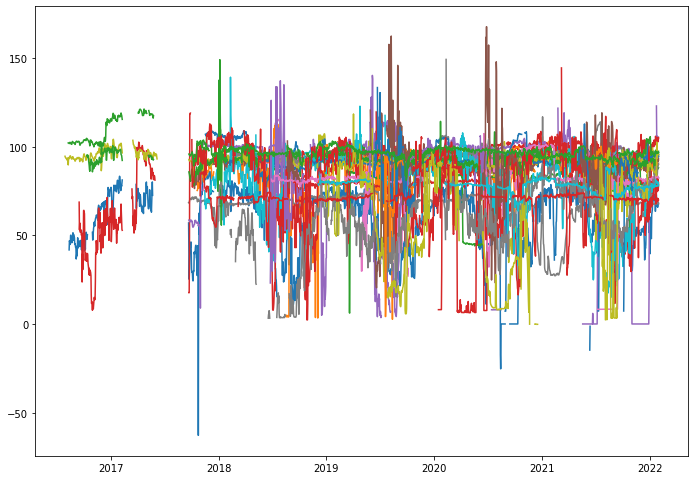

In [84]:
plt.plot(pHdata)

In [75]:
hello = pHdata.iloc[:, [1,10,27,30]]
hello.interpolate('time', limit_direction='both')

value                               
siteID             BARC      FLNT       SUGG      TOMB
startDateTime                                         
2016-03-04     6.423184  0.661200  14.115730  0.000000
2016-03-05     6.423184  0.661200  14.115730  0.000000
2016-03-06     6.423184  0.661200  14.115730  0.000000
2016-03-07     6.423184  0.661200  14.115730  0.000000
2016-03-08     6.423184  0.661200  14.115730  0.000000
...                 ...       ...        ...       ...
2022-01-27     0.969896  1.653206   8.407465  7.368182
2022-01-28     0.963542  1.526167   8.475347  7.368182
2022-01-29     0.930347  1.564564   8.434965  7.368182
2022-01-30     0.924722  1.582042   8.541806  7.368182
2022-01-31     0.862396  1.412927   8.715312  7.368182

[2160 rows x 4 columns]

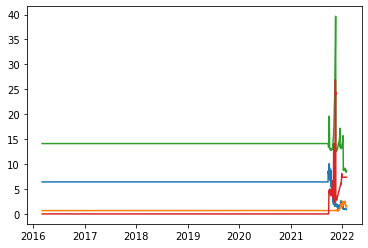

In [76]:
plt.plot(hello.interpolate('time', limit_direction='both'))

In [69]:
pHdata.iloc[:, [1,10,27,30]]

value                         
siteID             BARC      FLNT      SUGG TOMB
startDateTime                                   
2016-03-04          NaN       NaN       NaN  NaN
2016-03-05          NaN       NaN       NaN  NaN
2016-03-06          NaN       NaN       NaN  NaN
2016-03-07          NaN       NaN       NaN  NaN
2016-03-08          NaN       NaN       NaN  NaN
...                 ...       ...       ...  ...
2022-01-27     0.969896  1.653206  8.407465  NaN
2022-01-28     0.963542  1.526167  8.475347  NaN
2022-01-29     0.930347  1.564564  8.434965  NaN
2022-01-30     0.924722  1.582042  8.541806  NaN
2022-01-31     0.862396  1.412927  8.715312  NaN

[2160 rows x 4 columns]

In [85]:
pHdata.to_csv('/Users/athenaye/Desktop/ox.csv')

In [36]:
pHdata.columns

MultiIndex([('value', 'ARIK'),
            ('value', 'BARC'),
            ('value', 'BIGC'),
            ('value', 'BLDE'),
            ('value', 'BLUE'),
            ('value', 'BLWA'),
            ('value', 'CARI'),
            ('value', 'COMO'),
            ('value', 'CRAM'),
            ('value', 'CUPE'),
            ('value', 'FLNT'),
            ('value', 'GUIL'),
            ('value', 'HOPB'),
            ('value', 'KING'),
            ('value', 'LECO'),
            ('value', 'LEWI'),
            ('value', 'LIRO'),
            ('value', 'MART'),
            ('value', 'MAYF'),
            ('value', 'MCDI'),
            ('value', 'MCRA'),
            ('value', 'OKSR'),
            ('value', 'POSE'),
            ('value', 'PRIN'),
            ('value', 'PRLA'),
            ('value', 'PRPO'),
            ('value', 'REDB'),
            ('value', 'SUGG'),
            ('value', 'SYCA'),
            ('value', 'TECR'),
            ('value', 'TOMB'),
            ('value', 'TOOK'),
        

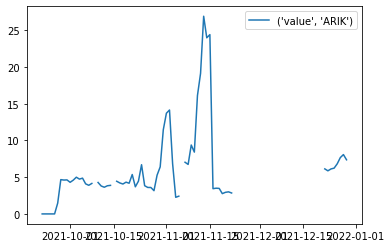

In [70]:
plt.plot(pHdata.iloc[:, 30])
plt.legend(pHdata.columns)

In [ ]:
BARC 1, FLNT 10 , SUGG 27, TOMB 30

In [43]:
pHdata.iloc[:, 0:2]

value          
siteID         ARIK      BARC
startDateTime                
2016-03-04      NaN       NaN
2016-03-05      NaN       NaN
2016-03-06      NaN       NaN
2016-03-07      NaN       NaN
2016-03-08      NaN       NaN
...             ...       ...
2022-01-27      NaN  0.969896
2022-01-28      NaN  0.963542
2022-01-29      NaN  0.930347
2022-01-30      NaN  0.924722
2022-01-31      NaN  0.862396

[2160 rows x 2 columns]

In [10]:
a

array([nan, nan, nan, ..., nan, nan, nan])

/Users/athenaye/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7035: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
<ipython-input-8-9c7cba4119ad>:25: RuntimeWarning: divide by zero encountered in true_divide
  aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = ['chlaRelativeFluorescence'])


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]


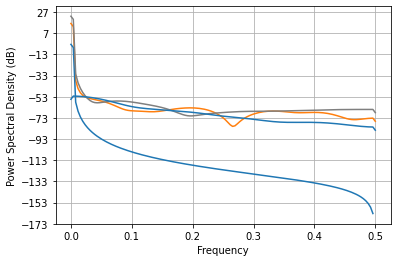

In [8]:
pHdata = pd.read_csv('/Users/athenaye/Desktop/Complete Data/chlaRelativeFluorescence.csv', index_col = 'startDateTime')
pHdata.index = pd.to_datetime(pHdata.index)
pHdata = pHdata.drop('Unnamed: 0', axis = 1)
pHdata
pHdata = pHdata[pHdata['variable'] == 'chlaRelativeFluorescence']
pHdata = pHdata.pivot(columns='siteID')[['value']]
for x in range(len(pHdata.columns)):
    nonan = pHdata[pHdata.columns[x]]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**8)
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
aphmean = acumulative.mean(axis=(0))
bphmean = bcumulative.mean(axis=(0))
aphmean = pd.DataFrame(aphmean, index = bphmean)
base = sci.interpolate.interp1d(1/aphmean.index[1:],aphmean.iloc[1:,0], kind = 'nearest')
xvalues = np.linspace(1,6, num = 2**7+1, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
interparray = base(xvalues)
aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = ['chlaRelativeFluorescence'])
aphmean = aphmean/aphmean.max()
print(a)

<ipython-input-2-d5e9750d0e10>:22: RuntimeWarning: divide by zero encountered in true_divide
  a14mean = pd.DataFrame(interparray, index = 1/bmean, columns = ['avgoverall'])


avgoverall
inf           2.896839e+07
1.638400e+04  2.896839e+07
8.192000e+03  2.896839e+07
5.461333e+03  2.896839e+07
4.096000e+03  2.896839e+07
...                    ...
2.000977e+00  7.745784e+01
2.000733e+00  8.286773e+01
2.000488e+00  6.693449e+01
2.000244e+00  6.648045e+01
2.000000e+00  3.953501e+01

[8193 rows x 1 columns]

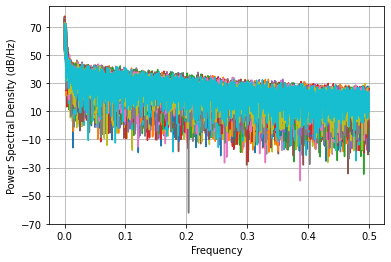

In [2]:
avgoverall = pd.read_csv('./PollenandBird/avgoverall.csv', index_col = 'date')
avgoverall.index = pd.to_datetime(avgoverall.index)
avgoverallsamp = avgoverall.iloc[:,0:50]
for x in range(len(avgoverallsamp.columns)):
    nonan = avgoverallsamp[avgoverallsamp.columns[x]]
    nonan = nonan.interpolate('linear', limit_direction = 'both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**14, detrend = 'linear')
    if x == 0:
        ameancumulative = a
        bmeancumulative = b
    else:
        ameancumulative = np.vstack([ameancumulative, a])
        bmeancumulative = np.vstack([bmeancumulative, b])
amean = ameancumulative.mean(axis=(0))
bmean = bmeancumulative.mean(axis=(0))
amean = pd.DataFrame(amean, index = bmean)
base = sci.interpolate.interp1d(1/amean.index[1:],amean.iloc[1:,0], kind = 'nearest')
xvalues = np.linspace(1,13, num = 2**(13)+1, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
interparray = base(xvalues)
a14mean = pd.DataFrame(interparray, index = 1/bmean, columns = ['avgoverall'])
# a14mean = a14mean/a14mean.max()
a14mean

# pH

In [13]:
#awndoverall.to_csv('./PollenandBird/awndoverall.csv')
pHdata = pd.read_csv('/Users/athenaye/Desktop/Complete Data/PARMean.csv', index_col = 'startDateTime')
pHdata.index = pd.to_datetime(pHdata.index)
pHdata = pHdata.drop('Unnamed: 0', axis = 1)
pHdata

siteID variable       value
startDateTime                            
2016-04-29      ABBY  PARMean  838.435000
2016-04-30      ABBY  PARMean  467.531111
2016-05-01      ABBY  PARMean  582.839236
2016-05-02      ABBY  PARMean  450.816250
2016-05-03      ABBY  PARMean  420.695556
...              ...      ...         ...
2022-01-27      DEJU  PARMean    5.875833
2022-01-28      DEJU  PARMean    4.698500
2022-01-29      DEJU  PARMean    6.383375
2022-01-30      DEJU  PARMean   20.555375
2022-01-31      DEJU  PARMean   22.602667

[32699 rows x 3 columns]

In [14]:
pHdata = pHdata[pHdata['variable'] == 'PARMean']
pHdata = pHdata.pivot(columns='siteID')[['value']]

In [15]:
pHdata.to_csv('/Users/athenaye/Desktop/indepth.csv')

<ipython-input-16-6352f533ae50>:19: RuntimeWarning: divide by zero encountered in true_divide
  aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = ['pH'])


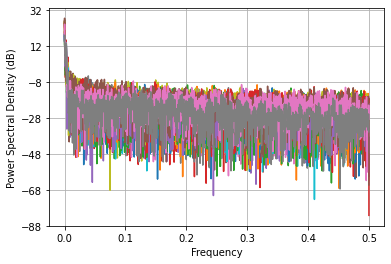

In [16]:
for x in range(len(pHdata.columns)):
    nonan = pHdata[pHdata.columns[x]]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14)
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
aphmean = acumulative.mean(axis=(0))
bphmean = bcumulative.mean(axis=(0))
aphmean = pd.DataFrame(aphmean, index = bphmean)
base = sci.interpolate.interp1d(1/aphmean.index[1:],aphmean.iloc[1:,0], kind = 'nearest')
xvalues = np.linspace(1,13, num = 8193, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
interparray = base(xvalues)
aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = ['pH'])


Text(0.5, 1.0, 'PARMean data')

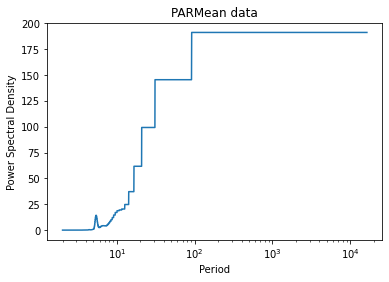

In [17]:
plt.semilogx(aphmean) #logs the x axis
plt.ylabel('Power Spectral Density')
plt.xlabel('Period')
plt.title('PARMean data')


In [163]:
aphmean

pH
inf           191.033180
1.638400e+04  191.033180
8.192000e+03  191.033180
5.461333e+03  191.033180
4.096000e+03  191.033180
...                  ...
2.000977e+00    0.005812
2.000733e+00    0.005509
2.000488e+00    0.007035
2.000244e+00    0.006510
2.000000e+00    0.002362

[8193 rows x 1 columns]

([<matplotlib.axis.XTick at 0x7fed09670a90>,
 [Text(8192.0, 0, '2d'),
  Text(7509.333446156619, 0, '4d'),
  Text(6826.666779477225, 0, '8d'),
  Text(6144.0, 0, '16d'),
  Text(5461.333446156619, 0, '32d'),
  Text(4778.666779477225, 0, '64d'),
  Text(4096.0, 0, '128d'),
  Text(3413.3334461566187, 0, '256d'),
  Text(3063.9768665044767, 0, '1yr'),
  Text(2381.3102969966953, 0, '2yr'),
  Text(1698.6436381508265, 0, '4yr'),
  Text(1015.9768665044764, 0, '8yr'),
  Text(333.31029699669557, 0, '16yr'),
  Text(0.0, 0, '8192d')])

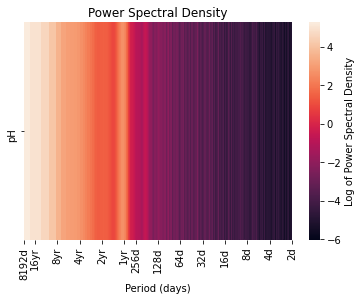

In [18]:
yvalues = np.array(range(0,8193))
xtickmarks = [2, 4,8,16,32,64,128,256,365, 365*2, 365*4, 365*8, 365*16, 8192]

x = xvalues
y = yvalues
f = sci.interpolate.interp1d(x, y)
xnew = xtickmarks #Starting period, ending period, interval of jump
ynew = f(xnew) # use interpolation function returned by `interp1d`
s = sns.heatmap(np.log(aphmean.T), cbar_kws={'label': 'Log of Power Spectral Density'})
s.set_title('Power Spectral Density')
#s.set_xscale("log", base = 2)
s.set_xlabel('Period (days)')
locs, labels = plt.xticks()
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr','4yr','8yr','16yr', '8192d']
plt.xticks(ynew,newlabel)

In [13]:
s = s.set_yscale("log")

In [14]:
s

([<matplotlib.axis.XTick at 0x7f8c84693910>,
 [Text(64.0, 0, '2d'),
  Text(51.20435545842735, 0, '4d'),
  Text(38.40650960255278, 0, '8d'),
  Text(25.60648614490491, 0, '16d'),
  Text(12.804308542581309, 0, '32d'),
  Text(0.0, 0, '64d')])

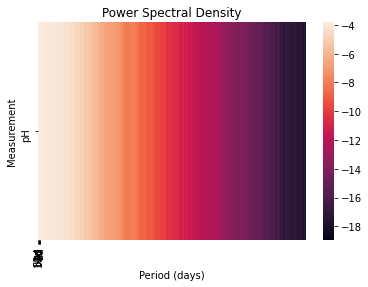

In [24]:
s = sns.heatmap(np.log(aphmean.T))
yvalues = np.array(range(0,65)) #y-values
xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)
xtickmarkloc = xtickmarkloc[0:6]
xvalues = np.linspace(1,6, num = 2**6+1, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
x = xvalues #the x-values to interpolate along??
y = yvalues #the y-values to interpolate along??
f = sci.interpolate.interp1d(x, y) #interpolating 
xnew = xtickmarkloc #the desired x-values
ynew = f(xnew) #list of values
#s = sns.heatmap(np.log(interpolated.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap x-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
newlabel = newlabel[0:6]
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels

### Detrended

In [54]:
dtpH = pd.DataFrame()
zpH = pd.DataFrame()
for x in range(len(pHdata.columns)):
    dtnonan = pHdata[pHdata.columns[x]]
    dtnonan = dtnonan.interpolate('time', limit_direction='both')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    zscore = stat.zscore(detrend)
    zscore = pd.DataFrame(zscore)
    zpH = pd.concat([zpH, zscore], axis = 1)
    dtpH = pd.concat([dtpH, detrend], axis = 1)

In [56]:
for x in range(len(dtpH.columns)):
    dtnonan = pHdata[pHdata.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    a,b = plt.psd(detrend, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
dtapH = acumulative.mean(axis=(0))
dtbpH = bcumulative.mean(axis=(0))

ValueError: array must not contain infs or NaNs

### Z-Scored

8193


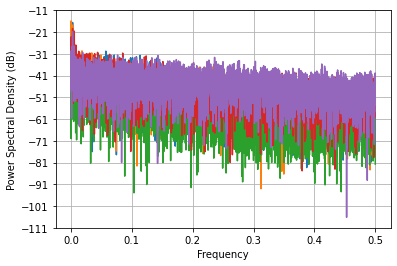

In [22]:
for x in range(len(zawnd.columns)):
    znonan = awndoverall[awndoverall.columns[x]]
    znonan = znonan.interpolate('linear')
    zscore = stat.zscore(znonan)
    zscore = pd.DataFrame(zscore)
    a,b = plt.psd(zscore, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
zaawnd = acumulative.mean(axis=(0))
zbawnd = bcumulative.mean(axis=(0))
print(a.size)

# AWND

In [4]:
#awndoverall.to_csv('./PollenandBird/awndoverall.csv')
awndoverall = pd.read_csv('./PollenandBird/awndoverall.csv', index_col = 'date')
awndoverall.index = pd.to_datetime(awndoverall.index)
awndoverall = awndoverall.drop('Unnamed: 0', axis = 1)

In [5]:
awndoverall

station AQW00061705  station FMW00040308  station GQW00041415  \
date                                                                        
1998-01-01                 25.0                 55.0                 58.0   
1998-01-02                 65.0                 47.0                 59.0   
1998-01-03                 94.0                 52.0                 60.0   
1998-01-04                 89.0                 48.0                 50.0   
1998-01-05                 43.0                 39.0                 62.0   
...                         ...                  ...                  ...   
2018-12-27                 21.0                 33.0                 51.0   
2018-12-28                 31.0                 24.0                 48.0   
2018-12-29                 28.0                 22.0                 50.0   
2018-12-30                 29.0                 34.0                 50.0   
2018-12-31                 44.0                 38.0                 60.0   

            station RQW00011641  station USC00244558  
date                                                  
1998-01-01                 38.0                 34.0  
1998-01-02                 40.0                 48.0  
1998-01-03                 49.0                 20.0  
1998-01-04                 45.0                  9.0  
1998-01-05                 28.0                 42.0  
...                         ...                  ...  
2018-12-27                 59.0                  1.0  
2018-12-28                 77.0                 17.0  
2018-12-29                 70.0                 44.0  
2018-12-30                 64.0                 43.0  
2018-12-31                 47.0                 11.0  

[7306 rows x 5 columns]

<ipython-input-12-50834b56d70b>:19: RuntimeWarning: divide by zero encountered in true_divide
  aawndmean = pd.DataFrame(interparray, index = 1/bawndmean, columns = ['AWND'])


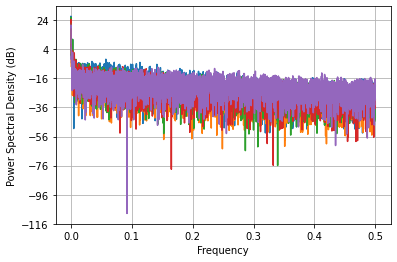

In [12]:
for x in range(len(awndoverall.columns)):
    nonan = awndoverall[awndoverall.columns[x]]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14)
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
aawndmean = acumulative.mean(axis=(0))
bawndmean = bcumulative.mean(axis=(0))
aawndmean = pd.DataFrame(aawndmean, index = bawndmean)
base = sci.interpolate.interp1d(1/aawndmean.index[1:],aawndmean.iloc[1:,0], kind = 'nearest')
xvalues = np.linspace(1,13, num = 8193, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
interparray = base(xvalues)
aawndmean = pd.DataFrame(interparray, index = 1/bawndmean, columns = ['AWND'])

### Detrended

In [20]:
dtawnd = pd.DataFrame()
zawnd = pd.DataFrame()
for x in range(len(awndoverall.columns)):
    dtnonan = awndoverall[awndoverall.columns[x]]
    dtnonan = dtnonan.interpolate('time', limit_direction='both')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    zscore = stat.zscore(detrend)
    zscore = pd.DataFrame(zscore)
    zawnd = pd.concat([zawnd, zscore], axis = 1)
    dtawnd = pd.concat([dtawnd, detrend], axis = 1)

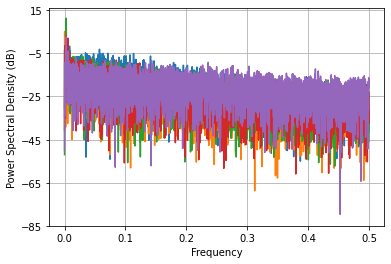

In [21]:
for x in range(len(dtawnd.columns)):
    dtnonan = awndoverall[awndoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    a,b = plt.psd(detrend, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
dtaawnd = acumulative.mean(axis=(0))
dtbawnd = bcumulative.mean(axis=(0))

### Z-Scored

8193


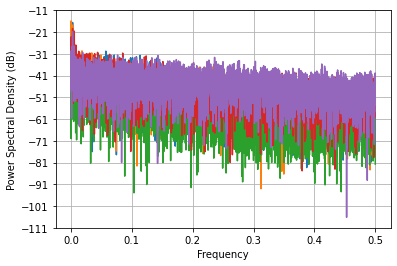

In [22]:
for x in range(len(zawnd.columns)):
    znonan = awndoverall[awndoverall.columns[x]]
    znonan = znonan.interpolate('linear')
    zscore = stat.zscore(znonan)
    zscore = pd.DataFrame(zscore)
    a,b = plt.psd(zscore, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
zaawnd = acumulative.mean(axis=(0))
zbawnd = bcumulative.mean(axis=(0))
print(a.size)

# TAVG

In [84]:
#awndoverall.to_csv('./PollenandBird/awndoverall.csv')
avgoverall = pd.read_csv('./PollenandBird/avgoverall.csv', index_col = 'date')
avgoverall.index = pd.to_datetime(avgoverall.index)

In [85]:
2**14

16384

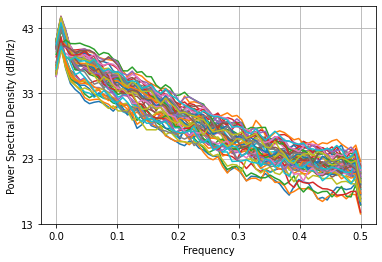

In [86]:
avgoverallsamp = avgoverall.iloc[:,0:50]
nfftnum = 7
for x in range(len(avgoverallsamp.columns)):
    nonan = avgoverallsamp[avgoverallsamp.columns[x]]
    nonan = nonan.interpolate('linear', limit_direction = 'both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**nfftnum, detrend = 'linear')
    if x == 0:
        ameancumulative = a
        bmeancumulative = b
    else:
        ameancumulative = np.vstack([ameancumulative, a])
        bmeancumulative = np.vstack([bmeancumulative, b])
amean = ameancumulative.mean(axis=(0))
bmean = bmeancumulative.mean(axis=(0))
amean = pd.DataFrame(amean, index = bmean)
base = sci.interpolate.interp1d(1/amean.index[1:],amean.iloc[1:,0], kind = 'nearest')
xvalues = np.linspace(1,nfftnum-1, num = 2**(nfftnum-1)+1, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
interparray = base(xvalues)
a7mean = pd.DataFrame(interparray, index = bmean, columns = ['TAVG'])

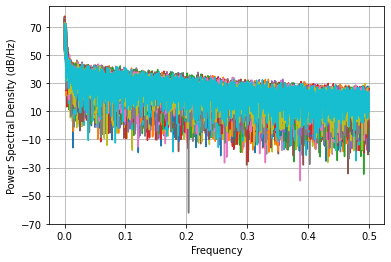

In [87]:
avgoverallsamp = avgoverall.iloc[:,0:50]
nfftnum = 14
for x in range(len(avgoverallsamp.columns)):
    nonan = avgoverallsamp[avgoverallsamp.columns[x]]
    nonan = nonan.interpolate('linear', limit_direction = 'both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**nfftnum, detrend = 'linear')
    if x == 0:
        ameancumulative = a
        bmeancumulative = b
    else:
        ameancumulative = np.vstack([ameancumulative, a])
        bmeancumulative = np.vstack([bmeancumulative, b])
amean = ameancumulative.mean(axis=(0))
bmean = bmeancumulative.mean(axis=(0))
amean = pd.DataFrame(amean, index = bmean)
base = sci.interpolate.interp1d(1/amean.index[1:],amean.iloc[1:,0], kind = 'nearest')
xvalues = np.linspace(1,nfftnum-1, num = 2**(nfftnum-1)+1, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
interparray = base(xvalues)
a14mean = pd.DataFrame(interparray, index = bmean, columns = ['TAVG'])

([<matplotlib.axis.XTick at 0x7fecdc8856a0>,
 [Text(64.0, 0, '2d'),
  Text(51.20435545842735, 0, '4d'),
  Text(38.40650960255278, 0, '8d'),
  Text(25.60648614490491, 0, '16d'),
  Text(12.804308542581309, 0, '32d'),
  Text(0.0, 0, '64d')])

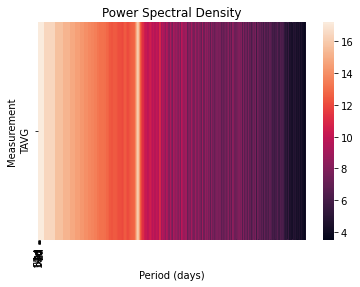

In [92]:
s = sns.heatmap(np.log(a14mean.T))
yvalues = np.array(range(0,65)) #y-values
xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)
xtickmarkloc = xtickmarkloc[0:6]
xvalues = np.linspace(1,6, num = 2**6+1, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
x = xvalues #the x-values to interpolate along??
y = yvalues #the y-values to interpolate along??
f = sci.interpolate.interp1d(x, y) #interpolating 
xnew = xtickmarkloc #the desired x-values
ynew = f(xnew) #list of values
#s = sns.heatmap(np.log(interpolated.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap x-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
newlabel = newlabel[0:6]
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels

<ipython-input-28-aacc8b67d042>:7: RuntimeWarning: divide by zero encountered in log
  s = sns.heatmap(np.log(both.T))


([<matplotlib.axis.XTick at 0x7fe256645880>,
 [Text(8192.0, 0, '2d'),
  Text(7509.333446156619, 0, '4d'),
  Text(6826.666779477225, 0, '8d'),
  Text(6144.0, 0, '16d'),
  Text(5461.333446156619, 0, '32d'),
  Text(4778.666779477225, 0, '64d'),
  Text(4096.0, 0, '128d'),
  Text(3413.3334461566187, 0, '256d'),
  Text(3063.9768665044767, 0, '1yr'),
  Text(2381.3102969966953, 0, '2yr'),
  Text(1698.6436381508265, 0, '4yr'),
  Text(1015.9768665044764, 0, '8yr'),
  Text(333.31029699669557, 0, '16yr')])

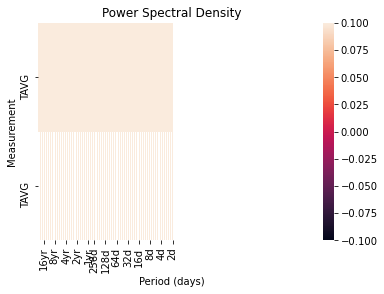

In [28]:
difference = len(a14mean)-len(a7mean)
both = pd.DataFrame()
newa7 = pd.DataFrame(a7mean)
for x in range(0, difference):
    newa7.loc[x] = 0
both = pd.concat([a14mean, newa7], axis = 1)
s = sns.heatmap(np.log(both.T))
yvalues = np.array(range(0,8193)) #y-values
xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)
xtickmarkloc = xtickmarkloc[0:13]
xvalues = np.linspace(1,13, num = 2**13+1, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
x = xvalues #the x-values to interpolate along??
x = xvalues #the x-values to interpolate along??
y = yvalues #the y-values to interpolate along??
f = sci.interpolate.interp1d(x, y) #interpolating 
xnew = xtickmarkloc #the desired x-values
ynew = f(xnew) #list of values
#s = sns.heatmap(np.log(interpolated.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap x-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
newlabel = newlabel[0:13]
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels

In [29]:
acum = pd.DataFrame(ameancumulative.T, 
                    columns = avgoverallsamp.columns, 
                    index = bmeancumulative[0])
bcum = pd.DataFrame(bmeancumulative.T, columns = avgoverallsamp.columns, index = bmeancumulative[0])

In [30]:
acumnonan = acum.dropna(axis = 1)

### Detrended

In [31]:
dt = pd.DataFrame()
zmean = pd.DataFrame()
for x in range(len(acumnonan.columns)):
    dtnonan = acumnonan[acumnonan.columns[x]]
    dtnonan = dtnonan.interpolate('time', limit_direction='both')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    zscore = stat.zscore(detrend)
    zscore = pd.DataFrame(zscore)
    zmean = pd.concat([zmean, zscore], axis = 1)
    dt = pd.concat([dt, detrend], axis = 1)

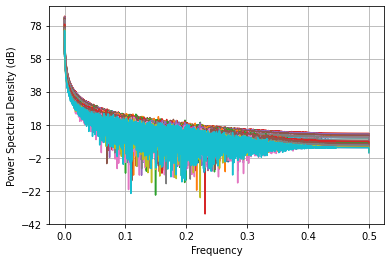

In [32]:
for x in range(len(dt.columns)):
    dtnonan = acumnonan[acumnonan.columns[x]]
    dtnonan = dtnonan.interpolate('time', limit_direction='both')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    a,b = plt.psd(detrend, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
dtamean = acumulative.mean(axis=(0))
dtbmean = bcumulative.mean(axis=(0))

### Z-Scored

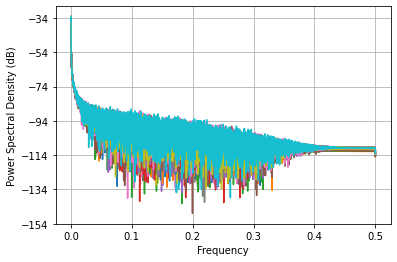

In [33]:
for x in range(len(acumnonan.columns)):
    znonan = acumnonan[acumnonan.columns[x]]
    znonan = znonan.interpolate('time', limit_direction='both')
    zscore = stat.zscore(znonan)
    zscore = pd.DataFrame(zscore)
    a,b = plt.psd(zscore, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
zamean = acumulative.mean(axis=(0))
zbmean = bcumulative.mean(axis=(0))

# TMAX

In [4]:
#awndoverall.to_csv('./PollenandBird/awndoverall.csv')
maxoverall = pd.read_csv('./PollenandBird/maxoverall.csv', index_col = 'date')
maxoverall.index = pd.to_datetime(maxoverall.index)

In [5]:
maxoverall

station AE000041196  station AEM00041194  station AEM00041217  \
date                                                                        
1998-01-01                261.0                254.0                272.0   
1998-01-02                  NaN                  NaN                  NaN   
1998-01-03                  NaN                  NaN                  NaN   
1998-01-04                  NaN                  NaN                  NaN   
1998-01-05                  NaN                  NaN                  NaN   
...                         ...                  ...                  ...   
2018-12-27                263.0                268.0                265.0   
2018-12-28                258.0                261.0                271.0   
2018-12-29                266.0                273.0                272.0   
2018-12-30                260.0                263.0                255.0   
2018-12-31                276.0                276.0                278.0   

            station AEM00041218  station AG000060390  
date                                                  
1998-01-01                276.0                155.0  
1998-01-02                265.0                165.0  
1998-01-03                  NaN                193.0  
1998-01-04                  NaN                217.0  
1998-01-05                  NaN                178.0  
...                         ...                  ...  
2018-12-27                259.0                  NaN  
2018-12-28                251.0                  NaN  
2018-12-29                262.0                  NaN  
2018-12-30                285.0                  NaN  
2018-12-31                266.0                  NaN  

[7665 rows x 5 columns]

[0.00000000e+00 6.10351562e-05 1.22070312e-04 ... 4.99877930e-01
 4.99938965e-01 5.00000000e-01]
                     0
0.000000  21302.813049
0.000061  29474.880578
0.000122   9644.767045
0.000183   2530.994029
0.000244   1583.929262
...                ...
0.499756      0.007007
0.499817      0.005234
0.499878      0.003247
0.499939      0.003009
0.500000      0.001631

[8193 rows x 1 columns]


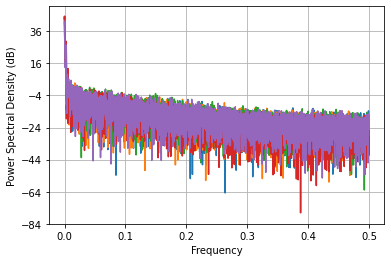

In [9]:
for x in range(len(maxoverall.columns)):
    nonan = maxoverall[maxoverall.columns[x]]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    
    if x == 0:
        tmaxacumulative = a
        tmaxbcumulative = b
    else:
        tmaxacumulative = np.vstack([tmaxacumulative, a])
        tmaxbcumulative = np.vstack([tmaxbcumulative, b])
tmaxamean = np.nanmean(tmaxacumulative, axis=(0))
tmaxbmean = np.nanmean(tmaxbcumulative, axis=(0))
print(tmaxbmean)
tmaxamean = pd.DataFrame(tmaxamean, index = tmaxbmean)
print(tmaxamean)
base = sci.interpolate.interp1d(1/tmaxamean.index[1:],tmaxamean.iloc[1:,0], kind = 'nearest')
xvalues = np.linspace(1,13, num = 8193, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
interparray = base(xvalues)
tmaxamean = pd.DataFrame(interparray, index = tmaxbmean, columns = ['TMAX'])

### Detrended

In [37]:
dttmax = pd.DataFrame()
ztmax = pd.DataFrame()
for x in range(len(maxoverall.columns)):
    dtnonan = maxoverall[maxoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    zscore = stat.zscore(detrend)
    zscore = pd.DataFrame(zscore)
    ztmax = pd.concat([ztmax, zscore], axis = 1)
    dttmax = pd.concat([dttmax, detrend], axis = 1)

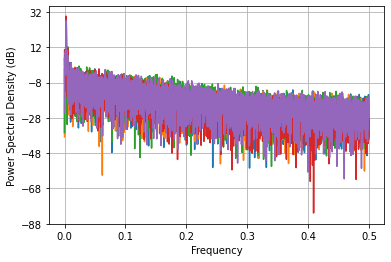

In [38]:
for x in range(len(dttmax.columns)):
    dtnonan = maxoverall[maxoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    a,b = plt.psd(detrend, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
dtatmax = acumulative.mean(axis=(0))
dtbtmax = bcumulative.mean(axis=(0))

### Z-Scored

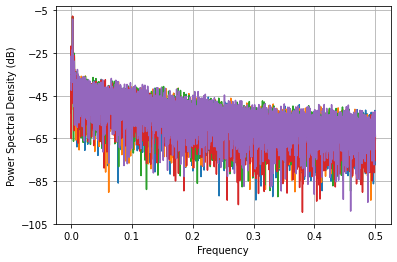

In [39]:
for x in range(len(ztmax.columns)):
    znonan = maxoverall[maxoverall.columns[x]]
    znonan = znonan.interpolate('linear')
    zscore = stat.zscore(znonan)
    zscore = pd.DataFrame(zscore)
    a,b = plt.psd(zscore, Fs = 1, scale_by_freq = False, NFFT = 2**14)
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
zatmax = acumulative.mean(axis=(0))
zbtmax = bcumulative.mean(axis=(0))

# TMIN

In [40]:
#minoverall.to_csv('./PollenandBird/minoverall.csv')
minoverall = pd.read_csv('./PollenandBird/minoverall.csv', index_col = 'date')
minoverall.index = pd.to_datetime(minoverall.index)

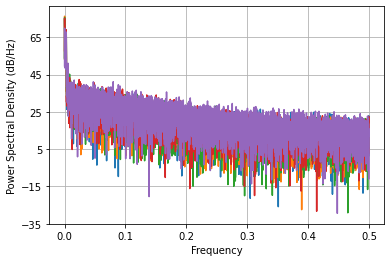

In [41]:
for x in range(len(minoverall.columns)):
    nonan = minoverall[minoverall.columns[x]]
    nonan = nonan.interpolate('time',limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**14, detrend = 'linear' )
    
    if x == 0:
        tminacumulative = a
        tminbcumulative = b
    else:
        tminacumulative = np.vstack([tminacumulative, a])
        tminbcumulative = np.vstack([tminbcumulative, b])
tminamean = np.nanmean(tminacumulative, axis=(0))
tminbmean = np.nanmean(tminbcumulative, axis=(0))
tminamean = pd.DataFrame(tminamean, index = tminbmean)
base = sci.interpolate.interp1d(1/tminamean.index[1:],tminamean.iloc[1:,0], kind = 'nearest')
xvalues = np.linspace(1,13, num = 8193, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
interparray = base(xvalues)
tminamean = pd.DataFrame(interparray, index = tminbmean, columns = ['TMIN'])

### Detrended

In [42]:
dttmin = pd.DataFrame()
ztmin = pd.DataFrame()
for x in range(len(minoverall.columns)):
    dtnonan = minoverall[minoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear', limit_direction = 'both')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    zscore = stat.zscore(detrend)
    zscore = pd.DataFrame(zscore)
    ztmin = pd.concat([ztmin, zscore], axis = 1)
    dttmin = pd.concat([dttmin, detrend], axis = 1)

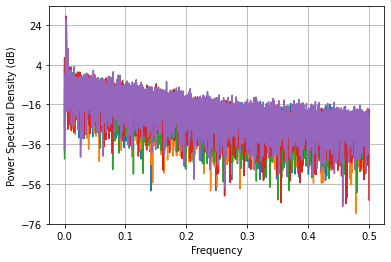

In [43]:
for x in range(len(minoverall.columns)):
    dtnonan = minoverall[minoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear', limit_direction = 'both')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    a,b = plt.psd(detrend, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
dtamin = acumulative.mean(axis=(0))
dtbmin = bcumulative.mean(axis=(0))

### Z-Scored

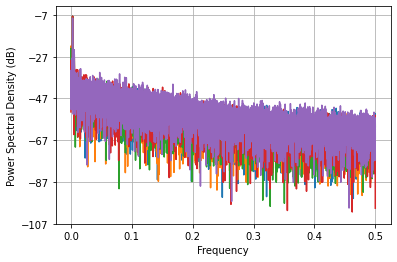

In [44]:
for x in range(len(minoverall.columns)):
    znonan = minoverall[minoverall.columns[x]]
    znonan = znonan.interpolate('linear', limit_direction = 'both')
    zscore = stat.zscore(znonan)
    zscore = pd.DataFrame(zscore)
    a,b = plt.psd(zscore, Fs = 1, scale_by_freq = False, NFFT = 2**14)
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
zamin = acumulative.mean(axis=(0))
zbmin = bcumulative.mean(axis=(0))

# PRCP

In [45]:
#prcpoverall.to_csv('./PollenandBird/prcpoverall.csv')
prcpoverall = pd.read_csv('./PollenandBird/prcpoverall.csv', index_col = 'date')
prcpoverall.index = pd.to_datetime(prcpoverall.index)

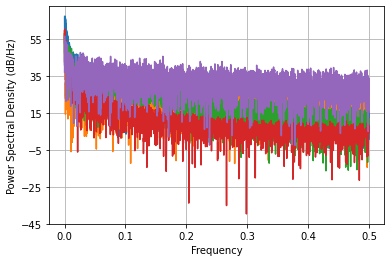

In [46]:
for x in range(len(prcpoverall.columns)):
    nonan = prcpoverall[prcpoverall.columns[x]]
    nonan = nonan.interpolate('time',limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**14, detrend = 'linear')
    
    if x == 0:
        prcpacumulative = a
        prcpbcumulative = b
    else:
        prcpacumulative = np.vstack([prcpacumulative, a])
        prcpbcumulative = np.vstack([prcpbcumulative, b])
prcpamean = np.nanmean(prcpacumulative, axis=(0))
prcpbmean = np.nanmean(prcpbcumulative, axis=(0))
prcpamean = pd.DataFrame(prcpamean, index = prcpbmean)
base = sci.interpolate.interp1d(1/prcpamean.index[1:],prcpamean.iloc[1:,0], kind = 'nearest')
xvalues = np.linspace(1,13, num = 8193, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
interparray = base(xvalues)
prcpamean = pd.DataFrame(interparray, index = prcpbmean, columns = ['PRCP'])

### Detrended

In [47]:
dtprcp = pd.DataFrame()
zprcp = pd.DataFrame()
for x in range(len(prcpoverall.columns)):
    dtnonan = prcpoverall[prcpoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    zscore = stat.zscore(detrend)
    zscore = pd.DataFrame(zscore)
    zprcp = pd.concat([zprcp, zscore], axis = 1)
    dtprcp = pd.concat([dtprcp, detrend], axis = 1)

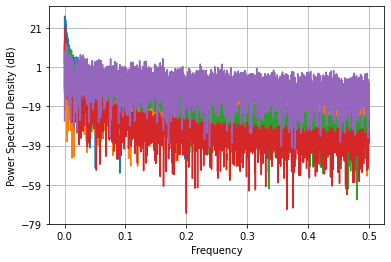

In [48]:
for x in range(len(prcpoverall.columns)):
    dtnonan = prcpoverall[prcpoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    a,b = plt.psd(detrend, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
dtaprcp = acumulative.mean(axis=(0))
dtbprcp = bcumulative.mean(axis=(0))

### Z-Scored

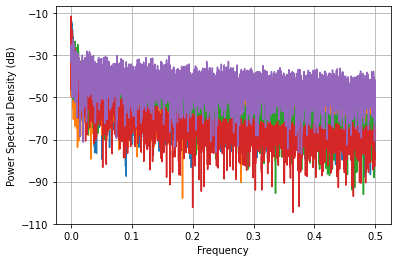

In [49]:
for x in range(len(prcpoverall.columns)):
    znonan = prcpoverall[prcpoverall.columns[x]]
    znonan = znonan.interpolate('linear')
    zscore = stat.zscore(znonan)
    zscore = pd.DataFrame(zscore)
    a,b = plt.psd(zscore, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
zaprcp = acumulative.mean(axis=(0))
zbprcp = bcumulative.mean(axis=(0))

# Bootstrapping

In [5]:
sampled = pd.DataFrame(avgoverall.iloc[:,0:5])

In [51]:
onestationyearly = sampled.set_index(sampled.index.year)
onestationyearly = onestationyearly.iloc[:,0]

In [52]:
years = sampled.index.year.drop_duplicates()
years = years.to_list()

                 0
0     15181.392398
1     21135.343814
2      7080.515680
3      1893.339903
4      1168.048256
...            ...
8188      0.003402
8189      0.006867
8190      0.007698
8191      0.004234
8192      0.000827

[8193 rows x 1 columns]


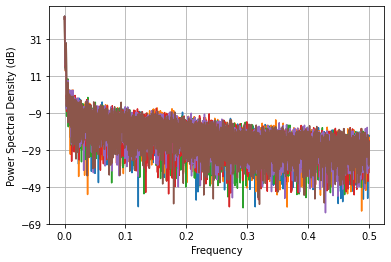

In [53]:
wholea = pd.DataFrame()
nonan = onestationyearly
nonan = nonan.interpolate('time',limit_direction='both')
a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
wholea = pd.DataFrame(a)
print(wholea)
numberofruns = 5
for x in range(numberofruns):
    boots = pd.DataFrame()
    random = np.random.choice(years, len(years))
    for q in range(len(years)):
        remade = onestationyearly.loc[[random[q]]]
        boots = pd.concat([boots, remade])
    nonan = boots[boots.columns[0]]
    nonan = nonan.interpolate('time',limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    bacumulative = pd.DataFrame(a)
    wholea = pd.concat([wholea, bacumulative], axis = 1)
wholea.index = b
wholea.columns = np.array(range(numberofruns+1))

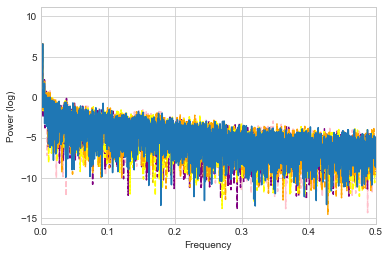

In [54]:
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.set(xlim=(0, 0.5),
       xlabel='Frequency', ylabel='Power (log)')
col = ['blue', 'pink','purple','yellow','orange','red'] 
for i in range(1,5):
    plt.plot(b,np.log(wholea.iloc[:,i]), '--', color = col[i])
plt.plot(b,np.log(a))

# 16-32 vs. 32+ Days Figure

In [6]:
overall = avgoverall.interpolate('time', limit_direction='both')
overall = pd.DataFrame(overall)
overall = overall.set_index(sampled.index.year)
overall.columns = overall.columns.str.replace("[station ]","")
overall

AE000041196  AEM00041194  AEM00041217  AEM00041218  AG000060390  \
date                                                                    
1998        195.0        210.0        204.0        212.0        105.0   
1998        218.0        232.0        234.0        219.0        114.0   
1998        188.0        194.0        204.0        195.0        148.0   
1998        205.0        226.0        224.0        218.0        136.0   
1998        216.0        218.0        232.0        223.0        132.0   
...           ...          ...          ...          ...          ...   
2018        187.0        217.0        203.0        197.0        103.0   
2018        187.0        216.0        202.0        196.0        133.0   
2018        195.0        219.0        209.0        204.0        111.0   
2018        202.0        222.0        207.0        216.0         96.0   
2018        206.0        227.0        214.0        213.0        112.0   

      AG000060590  AG000060611  AGE00147718  AGM00060351  AGM00060355  ...  \
date                                                                   ...   
1998         89.0        128.0        103.0        125.0        123.0  ...   
1998         97.0        107.0        128.0        132.0        135.0  ...   
1998        101.0         77.0        156.0        161.0        158.0  ...   
1998        142.0        109.0        163.0        147.0        152.0  ...   
1998        114.0         94.0        126.0        134.0        143.0  ...   
...           ...          ...          ...          ...          ...  ...   
2018        104.0        118.0        102.0        119.0        136.0  ...   
2018         82.0         99.0         92.0        124.0        129.0  ...   
2018        102.0         90.0         99.0        131.0        135.0  ...   
2018        106.0        106.0         98.0        120.0        140.0  ...   
2018         88.0         95.0        116.0        130.0        145.0  ...   

      USR0000WGOH  KG000036982  USR0000CSCN  BLM00085153  JA000047940  \
date                                                                    
1998         82.0       -201.0         39.0        185.0        273.0   
1998         82.0       -187.0         21.0        185.0        273.0   
1998         82.0       -204.0         17.0        185.0        273.0   
1998         82.0       -213.0         -1.0        185.0        273.0   
1998         82.0       -223.0        -21.0        185.0        273.0   
...           ...          ...          ...          ...          ...   
2018        -24.0       -188.0         33.0        291.0        186.0   
2018        -12.0       -217.0         34.0        294.0        147.0   
2018         22.0       -196.0         22.0        300.0        148.0   
2018        -16.0       -157.0         43.0        300.0        155.0   
2018        -38.0       -192.0         17.0        293.0        177.0   

      USR0000IBEA  RSM00028593  TZ000063832  USR0000CSCI  GHM00065459  
date                                                                   
1998         -3.0       -341.0        216.0        110.0        293.0  
1998        -20.0       -203.0        216.0        107.0        293.0  
1998        -20.0       -186.0        216.0         83.0        293.0  
1998        -48.0       -223.0        216.0         82.0        293.0  
1998        -76.0       -164.0        216.0         69.0        293.0  
...           ...          ...          ...          ...          ...  
2018        -93.0       -269.0        242.0        137.0        300.8  
2018       -100.0       -168.0        245.0         94.0        301.2  
2018        -71.0       -127.0        246.0         82.0        301.6  
2018        -74.0       -118.0        248.0        103.0        302.0  
2018       -132.0       -182.0        239.0        118.0        307.0  

[7665 rows x 3527 columns]

In [56]:
detrendedsamp = avgoverall.iloc[:,0::50].interpolate('time', limit_direction='both')
detrendedsamp = pd.DataFrame(detrendedsamp)
detrendedsamp = detrendedsamp.set_index(sampled.index.year)
detrendedsamp.columns = detrendedsamp.columns.str.replace("[station ]","")
detrendedsamp

AE000041196  AR000087692  ASN00010286  ASN00091311  BLM00085244  \
date                                                                    
1998        195.0        149.0        307.0        199.0        257.0   
1998        218.0        163.0        307.0        173.0        261.0   
1998        188.0        204.0        307.0        157.0        257.0   
1998        205.0        217.0        307.0        164.0        277.0   
1998        216.0        217.0        307.0        163.0        277.0   
...           ...          ...          ...          ...          ...   
2018        187.0        224.0        233.0        208.0        267.0   
2018        187.0        186.0        221.0        224.0        269.0   
2018        195.0        219.0        239.0        171.0        262.0   
2018        202.0        208.0        267.0        173.0        257.0   
2018        206.0        187.0        285.0        182.0        246.0   

      BRM00082098  CA007054096  CHM00052436  CHM00054346  CHM00056954  ...  \
date                                                                   ...   
1998        279.0      -203.00        -60.0        -81.0        141.0  ...   
1998        277.0      -112.00        -88.0        -61.0        146.0  ...   
1998        278.0      -106.25       -143.0       -101.0        139.0  ...   
1998        286.0      -100.50       -135.0       -131.0        125.0  ...   
1998        286.0       -94.75       -129.0        -83.0        125.0  ...   
...           ...          ...          ...          ...          ...  ...   
2018        275.0      -138.00       -198.0       -178.0        137.0  ...   
2018        259.0       -72.00       -198.0       -132.0        150.0  ...   
2018        259.0       -97.00       -179.0       -142.0        156.0  ...   
2018        270.0      -135.00       -137.0       -147.0        168.0  ...   
2018        279.0       -67.00       -139.0       -142.0        143.0  ...   

      USS0020B02S  USS0021C40S  USS0046Q01S  VMM00048806  KZ000035426  \
date                                                                    
1998          0.0        146.0       -280.0        187.0        -84.0   
1998        -68.0        146.0       -300.0        198.0        -84.0   
1998        -84.0        146.0       -240.0        203.0       -112.0   
1998        -55.0        146.0       -220.0        188.0       -163.0   
1998        -35.0        146.0       -240.0        188.0       -161.0   
...           ...          ...          ...          ...          ...   
2018        -31.0          6.0       -101.0        181.0        -63.0   
2018        -25.0         20.0       -112.0        170.0        -44.0   
2018         29.0         49.0       -163.0        124.0        -88.0   
2018        -16.0          5.0       -115.0         86.0       -118.0   
2018        -46.0        -13.0        -26.0         91.0       -104.0   

      PKM00041685  USR0000VCRA  UY000001709  RSM00028696  USR0000ISKU  
date                                                                   
1998        283.0        144.0        216.0       -329.0         12.0  
1998        283.0        144.0        216.0       -244.0          6.0  
1998        283.0        144.0        216.0       -218.0         -1.0  
1998        283.0        144.0        216.0       -287.0         -6.0  
1998        283.0        144.0        216.0       -216.0        -39.0  
...           ...          ...          ...          ...          ...  
2018        108.0          9.0        285.0        173.0        -77.0  
2018        111.0         88.0        312.0        173.0        -81.0  
2018        111.0         76.0        292.0        173.0        -66.0  
2018         98.0         72.0        272.0        173.0        -48.0  
2018        115.0         84.0        254.0        173.0       -119.0  

[7665 rows x 71 columns]

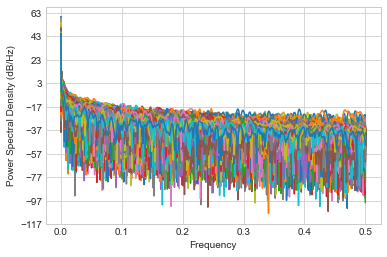

In [57]:
yearly1632 = pd.DataFrame()
yearly32plus = pd.DataFrame()
allratios = pd.DataFrame()
power = pd.DataFrame()
#rawdata = pd.DataFrame()
data = detrendedsamp
umappeddata = pd.DataFrame()
for s in range(len(data.columns)):
    ratios = pd.DataFrame()
    #rawdata = pd.DataFrame()
    sixteenthirtytwo = pd.DataFrame()
    thirtytwoplus = pd.DataFrame()
    for y in range(1998,2019):
        nonan = data.iloc[:,s].loc[y]
        nonan = nonan.interpolate('time', limit_direction='both')
        a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**14, detrend = 'linear')
        a = stat.zscore(a)
        a = pd.DataFrame(a, index = b)
        base = sci.interpolate.interp1d(1/a.index[1:],a.iloc[1:,0], kind = 'nearest')
        xvalues = np.linspace(1,13, num = 8193, endpoint = True)
        xvalues = xvalues[::-1]
        xvalues = 2**xvalues
        interparray = base(xvalues)
        plot1632 = pd.DataFrame(interparray, index = b, columns = [np.random.rand()*10])
        umapped = pd.DataFrame(interparray, index = b, columns = [str(data.columns[s]) + ': ' + str(y)])
        lower = plot1632.loc[0.03125:0.0625].mean()
        higher = plot1632.loc[0.015625:0.03125].mean()
        fraction = higher/lower
        ratios = pd.concat([ratios, fraction])
        sixteenthirtytwo = pd.concat([sixteenthirtytwo, lower])
        thirtytwoplus = pd.concat([thirtytwoplus, higher])
        power = pd.concat([power, plot1632], axis = 1)
        umappeddata = pd.concat([umappeddata, umapped], axis = 1)
    allratios = pd.concat([allratios, ratios], axis = 1)
    yearly1632 = pd.concat([yearly1632, sixteenthirtytwo], axis =1)
    yearly32plus = pd.concat([yearly32plus, thirtytwoplus], axis =1)
allratios.columns = avgoverall.columns[0::50]

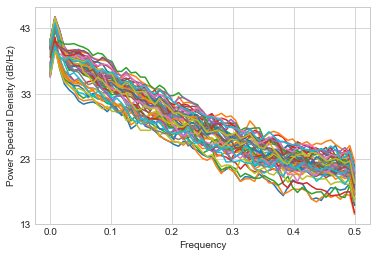

In [58]:
avgoverallsamp = avgoverall.iloc[:,0:50]
stationsonly7 = pd.DataFrame()
nfftnum = 7
for x in range(len(avgoverallsamp.columns)):
    nonan = avgoverallsamp[avgoverallsamp.columns[x]]
    nonan = nonan.interpolate('linear', limit_direction = 'both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**nfftnum, detrend = 'linear')
    a = stat.zscore(a)
    a = pd.DataFrame(a, index = b)
    base = sci.interpolate.interp1d(1/a.index[1:],a.iloc[1:,0], kind = 'nearest')
    xvalues = np.linspace(1,(nfftnum-1), num = 2**(nfftnum-1)+1, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    s7 = pd.DataFrame(interparray, index = b)
    stationsonly7 = pd.concat([stationsonly7, s7], axis = 1)

Text(0, 0.5, 'Ratio of Power of 32-64 Days/16-32 Days')

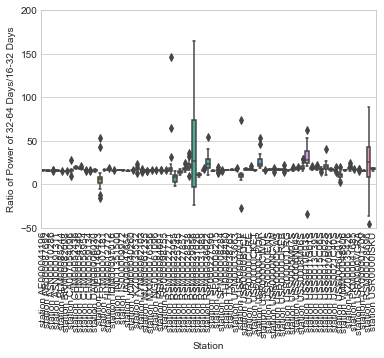

In [59]:
sns.boxplot(data = allratios)
plt.xlabel("Station")
plt.ylim(-50,200)
plt.xticks(rotation = 90)
plt.ylabel("Ratio of Power of 32-64 Days/16-32 Days")

Text(0, 0.5, 'Power of 32-64 Days')

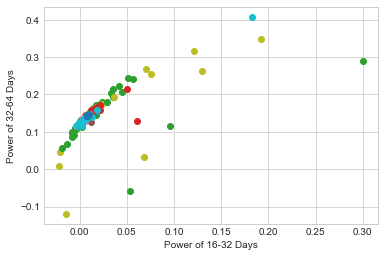

In [60]:
for i in range(len(yearly1632.columns)):
    plt.scatter(yearly1632.iloc[:,i], yearly32plus.iloc[:,i]) 
#plt.xlim(0.008,0.011)
#plt.ylim(0.1445,0.150)
plt.xlabel('Power of 16-32 Days')
plt.ylabel('Power of 32-64 Days')

# Stations

In [9]:
import umap
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3

# Dimension reduction and clustering libraries
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
sns.set(style = 'white', context = 'notebook', rc = {'figure.figsize':(14,10)})

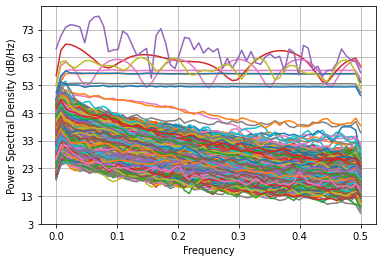

In [7]:
nfftstationsumapped = pd.DataFrame()
nfftstationsumappeddata = pd.DataFrame()
#data = detrendedsamp
data = overall
for s in range(len(data.columns)):
    nonan = data.iloc[:,s]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**7, detrend = 'linear')
    #a = stat.zscore(a)
    a = pd.DataFrame(a, index = b)
    base = sci.interpolate.interp1d(1/a.index[1:],a.iloc[1:,0], kind = 'nearest')
    xvalues = np.linspace(1,7, num = 65, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    nfftstationsumapped = pd.DataFrame(interparray, index = b, columns = [str(data.columns[s])])
    nfftstationsumappeddata = pd.concat([nfftstationsumappeddata, nfftstationsumapped], axis = 1)

In [12]:
nfftstationsumappeddata

AE000041196   AEM00041194   AEM00041217   AEM00041218  \
0.000000  10941.097697  10498.799849  11037.133699  14750.579505   
0.007812  10941.097697  10498.799849  11037.133699  14750.579505   
0.015625  10941.097697  10498.799849  11037.133699  14750.579505   
0.023438  10941.097697  10498.799849  11037.133699  14750.579505   
0.031250  10941.097697  10498.799849  11037.133699  14750.579505   
...                ...           ...           ...           ...   
0.468750     54.859419     57.797603     88.280130     83.062063   
0.476562     84.231024     69.244508     73.407760     82.885593   
0.484375     50.600942     43.874193     62.200830     68.898359   
0.492188     70.873103     55.743498     74.544871     55.292512   
0.500000     48.418906     28.322481     38.722869     30.098645   

           AG000060390   AG000060590   AG000060611   AGE00147718  AGM00060351  \
0.000000  10552.756616  24756.243898  20063.214022  20598.227557  9899.333669   
0.007812  10552.756616  24756.243898  20063.214022  20598.227557  9899.333669   
0.015625  10552.756616  24756.243898  20063.214022  20598.227557  9899.333669   
0.023438  10552.756616  24756.243898  20063.214022  20598.227557  9899.333669   
0.031250  10552.756616  24756.243898  20063.214022  20598.227557  9899.333669   
...                ...           ...           ...           ...          ...   
0.468750    104.971777    195.313304    160.404610    175.506822   214.706893   
0.476562    139.903950    185.582176    222.837700    138.895408   198.706307   
0.484375    139.555225    127.837581    113.453768    157.509690   150.045389   
0.492188    176.163604    171.805793    132.131456    117.193881   169.024415   
0.500000     57.675589    129.810455     64.764375     82.165396    72.874728   

          AGM00060355  ...   USR0000WGOH   KG000036982   USR0000CSCN  \
0.000000  9751.435325  ...  50350.314673  20501.841448  40008.350057   
0.007812  9751.435325  ...  50350.314673  20501.841448  40008.350057   
0.015625  9751.435325  ...  50350.314673  20501.841448  40008.350057   
0.023438  9751.435325  ...  50350.314673  20501.841448  40008.350057   
0.031250  9751.435325  ...  50350.314673  20501.841448  40008.350057   
...               ...  ...           ...           ...           ...   
0.468750   169.495812  ...    187.013459    300.273316    134.931032   
0.476562   140.769278  ...    221.013571    235.191164    198.084571   
0.484375   113.467012  ...    234.693240    309.359271     98.543472   
0.492188   122.301449  ...    179.658538    236.890308    130.043907   
0.500000    60.789964  ...    161.692170    103.225113     82.161704   

          BLM00085153  JA000047940   USR0000IBEA   RSM00028593  TZ000063832  \
0.000000  4901.017747  5399.964648  33440.118813  57259.350508  3819.358894   
0.007812  4901.017747  5399.964648  33440.118813  57259.350508  3819.358894   
0.015625  4901.017747  5399.964648  33440.118813  57259.350508  3819.358894   
0.023438  4901.017747  5399.964648  33440.118813  57259.350508  3819.358894   
0.031250  4901.017747  5399.964648  33440.118813  57259.350508  3819.358894   
...               ...          ...           ...           ...          ...   
0.468750   376.358778   101.202589    172.697662    696.313247   240.473632   
0.476562   276.246465   105.367751    175.007277    443.400179   186.125761   
0.484375   217.391002    88.054260    158.275415    492.017502   204.237162   
0.492188   224.739050    83.851231    132.696392    420.677922   164.048927   
0.500000   100.734045    39.528875     65.769955    240.033972   122.813716   

          USR0000CSCI  GHM00065459  
0.000000  8871.329464  1411.327849  
0.007812  8871.329464  1411.327849  
0.015625  8871.329464  1411.327849  
0.023438  8871.329464  1411.327849  
0.031250  8871.329464  1411.327849  
...               ...          ...  
0.468750   204.553804    50.031907  
0.476562   139.691872    62.688833  
0.484375   131.675542    69.285906  
0.492188   132.498868    45.518352  


In [15]:
stations = pd.read_csv('./PollenandBird/stations.csv', index_col="Station ID")
grid = pd.read_csv('./PollenandBird/grid.csv', index_col=["lat","long"])

In [16]:
overall.columns

Index(['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218',
       'AG000060390', 'AG000060590', 'AG000060611', 'AGE00147718',
       'AGM00060351', 'AGM00060355',
       ...
       'USR0000WGOH', 'KG000036982', 'USR0000CSCN', 'BLM00085153',
       'JA000047940', 'USR0000IBEA', 'RSM00028593', 'TZ000063832',
       'USR0000CSCI', 'GHM00065459'],
      dtype='object', length=3527)

In [17]:
stations.loc[overall.columns]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['ARM00087022', 'ARM00087046', 'ARM00087121', 'ARM00087166',\n       'ARM00087178',\n       ...\n       'MZM00067341', 'ARM00087641', 'BGM00041936', 'ARM00087320',\n       'MZM00067315'],\n      dtype='object', length=43). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [18]:
stationslatlongclassname = stations.loc[overall.columns]
stationslatlongclassname['Class'] = classofstation

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['ARM00087022', 'ARM00087046', 'ARM00087121', 'ARM00087166',\n       'ARM00087178',\n       ...\n       'MZM00067341', 'ARM00087641', 'BGM00041936', 'ARM00087320',\n       'MZM00067315'],\n      dtype='object', length=43). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [19]:
stationslatlongclassname.to_csv('/Users/athenaye/Desktop/stationslatlongclassname.csv')

NameError: name 'stationslatlongclassname' is not defined

In [20]:
colorofstation = list()
for x in range(len(overall.columns)):
    if overall.columns[x] in stations.index: 
        latoutput = ((round((stations.loc[overall.columns[x]]['latitude'] - 0.25) * 2)) / 2) + 0.25
        longoutput = ((round((stations.loc[overall.columns[x]]['longitude'] - 0.25) * 2)) / 2) + 0.25
        try:
            colorofstation.append(grid.loc[latoutput, longoutput]['colors'])
        except:
            cooList = grid.index
            coordinate = (latoutput, longoutput)
            nearest = min(cooList, key=lambda x: math.dist(x, coordinate))
            colorofstation.append(grid.loc[nearest]['colors'])

In [21]:
classofstation = list()
for x in range(len(overall.columns)):
    if overall.columns[x] in stations.index: 
        latoutput = ((round((stations.loc[overall.columns[x]]['latitude'] - 0.25) * 2)) / 2) + 0.25
        longoutput = ((round((stations.loc[overall.columns[x]]['longitude'] - 0.25) * 2)) / 2) + 0.25
        try:
            classofstation.append(grid.loc[latoutput, longoutput]['class'].lstrip())
        except:
            cooList = grid.index
            coordinate = (latoutput, longoutput)
            nearest = min(cooList, key=lambda x: math.dist(x, coordinate))
            classofstation.append(grid.loc[nearest]['class'].lstrip())

In [22]:
classofstation

['BWh',
 'BWh',
 'BWh',
 'BWh',
 'Csa',
 'BWh',
 'BWh',
 'BWh',
 'Csa',
 'Csa',
 'Csa',
 'Csa',
 'Csa',
 'Csa',
 'Csa',
 'Csa',
 'BSk',
 'BSk',
 'BSh',
 'BSk',
 'BWk',
 'BSk',
 'BSk',
 'BWk',
 'BSk',
 'BWh',
 'BWh',
 'BWk',
 'BWh',
 'BWh',
 'BWh',
 'BWh',
 'BWh',
 'BWh',
 'BWh',
 'BWh',
 'BWh',
 'BWh',
 'BSk',
 'Csa',
 'Cfa',
 'BSh',
 'Cfa',
 'BSh',
 'Cfa',
 'Cfa',
 'Cwa',
 'BWk',
 'Cfa',
 'Cfa',
 'Cfb',
 'BSk',
 'Csb',
 'BSk',
 'BSk',
 'BSk',
 'Cfa',
 'Aw',
 'Cfa',
 'BSh',
 'BSh',
 'BWh',
 'BWh',
 'BWh',
 'Csa',
 'Csa',
 'Csa',
 'Csb',
 'Csb',
 'Csb',
 'BSk',
 'BSk',
 'BWh',
 'BSh',
 'BWh',
 'Aw',
 'Aw',
 'Aw',
 'BSh',
 'BWh',
 'BWh',
 'BWh',
 'BWh',
 'BSk',
 'Csa',
 'BSk',
 'Csb',
 'Csb',
 'Aw',
 'BSh',
 'Am',
 'Aw',
 'Cwa',
 'BSh',
 'Cfa',
 'Cfa',
 'Cfa',
 'Cfa',
 'Cfa',
 'BSh',
 'BSh',
 'Cfa',
 'Cfa',
 'Cfa',
 'Cfa',
 'Cfa',
 'Cfa',
 'Cfa',
 'Cfa',
 'Cfb',
 'Cfb',
 'Cfb',
 'Cfa',
 'Cfb',
 'Cfb',
 'Cfb',
 'Cfb',
 'Cfb',
 'Csb',
 'Cfb',
 'Cfb',
 'Cfb',
 'Cfb',
 'Cfb',
 'EF',
 'EF',
 

In [23]:
def non_match_elements(a, b):
    non_match = []
    for i in a:
        if i not in b:
            non_match.append(i)
    return non_match

In [24]:
eqdist = pd.DataFrame()
eqdistind = pd.DataFrame()
for l in range(len(overall.T)):
    stationlookup = str(overall.T.index[l])
    if stationlookup in stations.index: 
        distfromeq = 0 + stations.loc[stationlookup][0]
        eqdistind = np.append(eqdistind, stationlookup)
        eqdist = np.append(eqdist, distfromeq)
        eqdist = pd.DataFrame(eqdist)
eqdist.index = eqdistind

In [ ]:
a = nfftstationsumappeddata.T.index
b = eqdist.index

non_match = non_match_elements(a, b)

In [25]:
overall = overall.drop(non_match, 1)

NameError: name 'non_match' is not defined

In [26]:
overallwclass = overall.T
overallwclass['class'] = classofstation
overallwclass = overallwclass

ValueError: Length of values (3484) does not match length of index (3527)

In [27]:
listofclasses = pd.DataFrame(overallwclass['class'].drop_duplicates())
listofclasses = listofclasses.applymap(lambda x: x.strip() if isinstance(x, str) else x)
listofclasses = list(listofclasses['class'])

KeyError: 'class'

In [28]:
justAf = overallwclass.loc[overallwclass['class'] == "Af"] 
justAf = justAf.iloc[:,0:7665]

KeyError: 'class'

In [29]:
justAf

NameError: name 'justAf' is not defined

In [30]:
justAf.columns = range(0,7665)

NameError: name 'justAf' is not defined

In [31]:
justAftrial = pd.melt(frame = justAf,
             var_name = 'column',
             value_name = 'value')

NameError: name 'justAf' is not defined

In [32]:
justAftrial

NameError: name 'justAftrial' is not defined

In [33]:
justAftrial

NameError: name 'justAftrial' is not defined

NameError: name 'justAftrial' is not defined

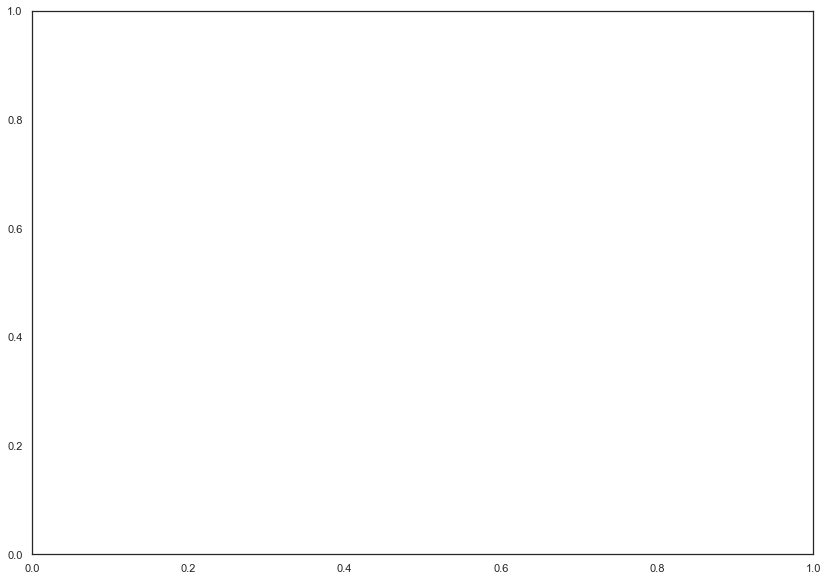

In [34]:
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = justAftrial,
             x = 'column',
             y = 'value')

plt.show()

In [35]:
def bootstrapclasses(whichclass):
    oneclassavg7 = pd.DataFrame()
    classcolumn = []
    for x in range(len(whichclass)):
        oneclass = overallwclass.loc[overallwclass['class'] == whichclass[x]] 
        oneclassavg = pd.DataFrame(oneclass)
        oneclassavg.columns = range(0,7666)
        oneclassavg.index = oneclassavg.index.str.replace("[station ]","")
        nfftnum = 7
        print(len(oneclassavg))
        for y in range(len(oneclassavg)):
            nonan = oneclassavg.iloc[y,0:7665]
            nonan = nonan.interpolate('linear', limit_direction = 'both')
            nonan = nonan.astype(float)
            a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**nfftnum, detrend = 'linear')
            #a = stat.zscore(a)
            a = pd.DataFrame(a, index = b)
            oneclassavg7 = pd.concat([oneclassavg7, a], axis = 0)
            for t in range(65):
                classcolumn.append(whichclass[x])
            #print(len(classcolumn))
    oneclassavg7['classlist'] = classcolumn
    #print(oneclassavg7)
    fig, ax = plt.subplots()
    s = sns.lineplot(x = oneclassavg7.index,
                 y = np.log(oneclassavg7[0]),
                hue = oneclassavg7['classlist'])
    
#     hi = np.array(oneclassavg7.index[1:])
#     nfftexpnew = 7
#     interpolated = pd.DataFrame()
#     base = sci.interpolate.interp1d(1/hi,oneclassavg7.iloc[1:,x], kind = 'nearest')
#     xvalues = np.linspace(1,nfftexpnew-1, num = 8193, endpoint = True)
#     xvalues = xvalues[::-1]
#     xvalues = 2**xvalues
#     interparray = base(xvalues)
#     series = pd.Series(interparray, index = xvalues)
#     interpolated = pd.concat([interpolated, series], axis = 1)
#     interpolated.rename_axis('frequency')
#     interpolated.rename_axis('measurement', axis='columns')
#     yvalues = np.array(range(0,8193)) #y-values
#     xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)
#     xtickmarkloc = xtickmarkloc[0:nfftexpnew-1]
#     x = xvalues #the x-values to interpolate along??
#     y = yvalues #the y-values to interpolate along??
#     f = sci.interpolate.interp1d(x, y) #interpolating 
#     xnew = xtickmarkloc #the desired x-values
#     ynew = f(xnew) #list of values
#     s = sns.lineplot(x = interpolated.index.T,
#                  y = np.log(interpolated.iloc[:,0].T))
#                 #hue = oneclassavg7['classlist']) #creating the heatmap and labeling the color bar
#     s.set_title('Power Spectral Density') #setting the heatmap title
#     s.set_xlabel('Period (days)') #setting the heatmap x-axis label
#     s.set_ylabel('Measurement') #setting the heatmap x-axis label
#     newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
#     newlabel = newlabel[0:nfftexpnew-1]
#     plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabel
    
# #make interpolated into 

In [ ]:
bootstrapclasses("Bwh")

In [ ]:
interpolated

In [ ]:
interpolated.iloc[:,1]

In [ ]:
#interpolated = interpolated.reset_index()
s = sns.lineplot(data = interpolated, x = 'index',
                 y = interpolated.iloc[:,1])
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap x-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
newlabel = newlabel[0:nfftexpnew-1]
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabel

In [ ]:
interpolated[0]

In [ ]:
bootstrapclasses(["BWh"])

In [ ]:
np.log(interpolated.iloc[:,0]).shape

In [ ]:
avg7overall = pd.DataFrame()
for x in range(len(listofclasses)):
    oneclass = overallwclass.loc[overallwclass['class'] == listofclasses[x]] 
    oneclassavg = pd.DataFrame(oneclass)
    oneclassavg.columns = range(0,7666)
    oneclassavg.index = oneclassavg.index.str.replace("[station ]","")
    oneclassavg7 = pd.DataFrame()
    nfftnum = 13
    for y in range(len(oneclassavg)):
        nonan = oneclassavg.iloc[y,0:7665]
        nonan = nonan.interpolate('linear', limit_direction = 'both')
        nonan = nonan.astype(float)
        a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**nfftnum, detrend = 'linear')
        #a = stat.zscore(a)
        a = pd.DataFrame(a, index = b)
        oneclassavg7 = pd.concat([oneclassavg7, a], axis = 1)
    avg7 = oneclassavg7.mean(axis = 1)
    avg7overall = pd.concat([avg7overall, avg7], axis = 1)
avg7overall.columns = listofclasses
avg7overall

In [ ]:
overallwclass

In [ ]:
def randomclass(classification):
    oneclass = overallwclass.loc[overallwclass['class'] == classification] 
    oneclassavg = pd.DataFrame(oneclass)
    print(len(oneclassavg))
    n = np.random.randint(0, len(oneclassavg))
    print(n)
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(oneclassavg.iloc[n])
    ax2.psd(oneclassavg[n], Fs = 1, scale_by_freq = True, NFFT = 2**nfftnum, detrend = 'linear')

In [ ]:
avg7overall.iloc[3000:3100].abs().max()[1]

In [ ]:
avg7overall.iloc[3000:3100].abs().max()

In [ ]:
hi = np.array(normavg7overall.index[1:])
nfftexpnew = 14
interpolated = pd.DataFrame()
for x in range(len(normavg7overall.columns)):
    base = sci.interpolate.interp1d(1/hi,normavg7overall.iloc[1:,x], kind = 'nearest')
    xvalues = np.linspace(1,nfftexpnew-1, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    series = pd.Series(interparray, index = xvalues)
    interpolated = pd.concat([interpolated, series], axis = 1)
    interpolated.rename_axis('frequency')
    interpolated.rename_axis('measurement', axis='columns')
yvalues = np.array(range(0,8193)) #y-values
xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)
xtickmarkloc = xtickmarkloc[0:nfftexpnew-1]
x = xvalues #the x-values to interpolate along??
y = yvalues #the y-values to interpolate along??
f = sci.interpolate.interp1d(x, y) #interpolating 
xnew = xtickmarkloc #the desired x-values
ynew = f(xnew) #list of values
interpolated.columns = normavg7overall.columns
s = sns.heatmap(np.log(interpolated.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap x-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
newlabel = newlabel[0:nfftexpnew-1]
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels

In [ ]:
normavg7overall = pd.DataFrame()
for x in range(len(avg7overall.columns)):
    normavg7overall[x] = avg7overall.iloc[:,x]/avg7overall.iloc[:,x].abs().max()
normavg7overall.columns = avg7overall.columns

In [ ]:
avg7overall

In [ ]:
avg7overall.iloc[15:30]

In [ ]:
avg7overall.max()

In [ ]:
avg7overall.iloc[15:30].abs().max()

In [ ]:
yearnormavg7overall = pd.DataFrame()
for x in range(len(avg7overall.columns)):
    yearnormavg7overall[x] = avg7overall.iloc[:,x]/avg7overall.iloc[15:30].abs().max()[x]
yearnormavg7overall.columns = avg7overall.columns

In [ ]:
yearnormavg7overall

In [ ]:
hi = np.array(yearnormavg7overall.index[1:])
nfftexpnew = 14
interpolated = pd.DataFrame()
for x in range(len(yearnormavg7overall.columns)):
    base = sci.interpolate.interp1d(1/hi,yearnormavg7overall.iloc[1:,x], kind = 'nearest')
    xvalues = np.linspace(1,nfftexpnew-1, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    series = pd.Series(interparray, index = xvalues)
    interpolated = pd.concat([interpolated, series], axis = 1)
    interpolated.rename_axis('frequency')
    interpolated.rename_axis('measurement', axis='columns')
yvalues = np.array(range(0,8193)) #y-values
xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)
xtickmarkloc = xtickmarkloc[0:nfftexpnew-1]
x = xvalues #the x-values to interpolate along??
y = yvalues #the y-values to interpolate along??
f = sci.interpolate.interp1d(x, y) #interpolating 
xnew = xtickmarkloc #the desired x-values
ynew = f(xnew) #list of values
interpolated.columns = normavg7overall.columns
s = sns.heatmap(np.log(interpolated.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap x-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
newlabel = newlabel[0:nfftexpnew-1]
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels
plt.savefig('/Users/athenaye/Desktop/YearNormalizedKCC.pdf')

In [ ]:
hi = np.array(avg7overall.index[1:])
nfftexpnew = 14
interpolated = pd.DataFrame()
for x in range(len(avg7overall.columns)):
    base = sci.interpolate.interp1d(1/hi,avg7overall.iloc[1:,x], kind = 'nearest')
    xvalues = np.linspace(1,nfftexpnew-1, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    series = pd.Series(interparray, index = xvalues)
    interpolated = pd.concat([interpolated, series], axis = 1)
    interpolated.rename_axis('frequency')
    interpolated.rename_axis('measurement', axis='columns')
yvalues = np.array(range(0,8193)) #y-values
xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)
xtickmarkloc = xtickmarkloc[0:nfftexpnew-1]
x = xvalues #the x-values to interpolate along??
y = yvalues #the y-values to interpolate along??
f = sci.interpolate.interp1d(x, y) #interpolating 
xnew = xtickmarkloc #the desired x-values
ynew = f(xnew) #list of values
interpolated.columns = avg7overall.columns
s = sns.heatmap(np.log(interpolated.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap x-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
newlabel = newlabel[0:nfftexpnew-1]
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels
plt.savefig('/Users/athenaye/Desktop/NotNormalizedKCC.pdf')

In [ ]:
eq = eqdist.sort_values(0)

In [ ]:
eq

In [ ]:
colors = []
absdist = eqdist.abs()
for x in range(len(eqdist)):
    if int(absdist.iloc[x]) <= 23.5:
        colors.append('r')
    if int(absdist.iloc[x]) > 23.5 and int(absdist.iloc[x])  <= 40:
        colors.append('y')
    if int(absdist.iloc[x]) > 40 and int(absdist.iloc[x]) <= 60:
        colors.append('b')
    if int(absdist.iloc[x]) > 60 and int(absdist.iloc[x]) <= 90:
        colors.append('g')

In [10]:
um = umap.UMAP()
Y_umap = um.fit_transform(nfftstationsumappeddata.T)

In [13]:
nfftstationsumappeddata

AE000041196   AEM00041194   AEM00041217   AEM00041218  \
0.000000  10941.097697  10498.799849  11037.133699  14750.579505   
0.007812  10941.097697  10498.799849  11037.133699  14750.579505   
0.015625  10941.097697  10498.799849  11037.133699  14750.579505   
0.023438  10941.097697  10498.799849  11037.133699  14750.579505   
0.031250  10941.097697  10498.799849  11037.133699  14750.579505   
...                ...           ...           ...           ...   
0.468750     54.859419     57.797603     88.280130     83.062063   
0.476562     84.231024     69.244508     73.407760     82.885593   
0.484375     50.600942     43.874193     62.200830     68.898359   
0.492188     70.873103     55.743498     74.544871     55.292512   
0.500000     48.418906     28.322481     38.722869     30.098645   

           AG000060390   AG000060590   AG000060611   AGE00147718  AGM00060351  \
0.000000  10552.756616  24756.243898  20063.214022  20598.227557  9899.333669   
0.007812  10552.756616  24756.243898  20063.214022  20598.227557  9899.333669   
0.015625  10552.756616  24756.243898  20063.214022  20598.227557  9899.333669   
0.023438  10552.756616  24756.243898  20063.214022  20598.227557  9899.333669   
0.031250  10552.756616  24756.243898  20063.214022  20598.227557  9899.333669   
...                ...           ...           ...           ...          ...   
0.468750    104.971777    195.313304    160.404610    175.506822   214.706893   
0.476562    139.903950    185.582176    222.837700    138.895408   198.706307   
0.484375    139.555225    127.837581    113.453768    157.509690   150.045389   
0.492188    176.163604    171.805793    132.131456    117.193881   169.024415   
0.500000     57.675589    129.810455     64.764375     82.165396    72.874728   

          AGM00060355  ...   USR0000WGOH   KG000036982   USR0000CSCN  \
0.000000  9751.435325  ...  50350.314673  20501.841448  40008.350057   
0.007812  9751.435325  ...  50350.314673  20501.841448  40008.350057   
0.015625  9751.435325  ...  50350.314673  20501.841448  40008.350057   
0.023438  9751.435325  ...  50350.314673  20501.841448  40008.350057   
0.031250  9751.435325  ...  50350.314673  20501.841448  40008.350057   
...               ...  ...           ...           ...           ...   
0.468750   169.495812  ...    187.013459    300.273316    134.931032   
0.476562   140.769278  ...    221.013571    235.191164    198.084571   
0.484375   113.467012  ...    234.693240    309.359271     98.543472   
0.492188   122.301449  ...    179.658538    236.890308    130.043907   
0.500000    60.789964  ...    161.692170    103.225113     82.161704   

          BLM00085153  JA000047940   USR0000IBEA   RSM00028593  TZ000063832  \
0.000000  4901.017747  5399.964648  33440.118813  57259.350508  3819.358894   
0.007812  4901.017747  5399.964648  33440.118813  57259.350508  3819.358894   
0.015625  4901.017747  5399.964648  33440.118813  57259.350508  3819.358894   
0.023438  4901.017747  5399.964648  33440.118813  57259.350508  3819.358894   
0.031250  4901.017747  5399.964648  33440.118813  57259.350508  3819.358894   
...               ...          ...           ...           ...          ...   
0.468750   376.358778   101.202589    172.697662    696.313247   240.473632   
0.476562   276.246465   105.367751    175.007277    443.400179   186.125761   
0.484375   217.391002    88.054260    158.275415    492.017502   204.237162   
0.492188   224.739050    83.851231    132.696392    420.677922   164.048927   
0.500000   100.734045    39.528875     65.769955    240.033972   122.813716   

          USR0000CSCI  GHM00065459  
0.000000  8871.329464  1411.327849  
0.007812  8871.329464  1411.327849  
0.015625  8871.329464  1411.327849  
0.023438  8871.329464  1411.327849  
0.031250  8871.329464  1411.327849  
...               ...          ...  
0.468750   204.553804    50.031907  
0.476562   139.691872    62.688833  
0.484375   131.675542    69.285906  
0.492188   132.498868    45.518352  


In [11]:
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c = np.array(range(0,3527)))
plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (nfftstationsumappeddata.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
um = umap.UMAP()
Y_umap1 = um.fit_transform(nfftstationsumappeddata.T.drop(non_match,0))

In [ ]:
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap1[:, 0], Y_umap1[:, 1], c = abs(eqdist[0]))
plt.colorbar(sc, label='Latitude')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (nfftstationsumappeddata.T.drop(non_match,0).index)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap1[:, 0], Y_umap1[:, 1], color = colorofstation)
#plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (overall.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
stations = pd.read_csv("./NOAAData/ghcnd-stations.csv", header = None, index_col = 0, names = ['Station ID', 'latitude', 'longitude', 'elevation', 'Station name'])

In [ ]:
def findstation(stationcode):
    overallcol = ['blue','red','purple']
    fig, (ax1, ax2) = plt.subplots(2)
    for l in range(len(stationcode)):
        for x in range(len(stationcode[l])):
            stationname = 'station '+str(stationcode[l][x])
            column = avgoverall.columns.get_loc(stationname)
            nonan = avgoverall.iloc[:,column]
            nonan = nonan.interpolate('time', limit_direction='both')
            z,y = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**7, detrend = 'linear')
            z = pd.DataFrame(z,  index = y)
            ax2.plot(z, overallcol[l])
            ax1.plot(nonan, overallcol[l])

In [ ]:
findstation((['RP000098755', 'TH000048450', 'ASN00091311'], ['USR0000BUCF', 'USS0017D02S'], ['RSM00029956', 'RSM00031026']))

In [ ]:
stationname = 'station JA000047654'
#fig, (ax1, ax2) = plt.subplots(2)
column = avgoverall.columns.get_loc(stationname)
nonan = avgoverall.iloc[:,column]
nonan = nonan.interpolate('time', limit_direction='both')

c,d = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**14, detrend = 'linear')
a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**7, detrend = 'linear',linewidth=4.0)

In [ ]:
import csv

txt_file = r"/Users/athenaye/Downloads/ghcnd-stations.txt"
csv_file = r"./NOAAData/ghcnd-stations.csv"

with open(txt_file, "r") as in_text:
    in_reader = csv.reader(in_text, delimiter = '\t')
    with open(csv_file, "w") as out_csv:
        out_writer = csv.writer(out_csv, delimiter =',') #, newline='')
        for row in in_reader:
            out_writer.writerow(row)

In [ ]:
dataframe = pd.read_csv("/Users/athenaye/Downloads/ghcnd-stations.txt",delimiter="\t", header = None)

# UMAP for station:year

In [ ]:
def findstationyear(year, stationcode):
    overallcol = ['blue','red','purple']
    fig, (ax1, ax2) = plt.subplots(2)
    for l in range(len(stationcode)):
        for x in range(len(stationcode[l])):
            startdate = str(year[l][x])+"-01-01"
            enddate = str(year[l][x])+"-12-31"
            stationname = 'station '+str(stationcode[l][x])
            column = avgoverall.columns.get_loc(stationname)
            starting = avgoverall.index.get_loc(startdate)
            ending = avgoverall.index.get_loc(enddate)
            nonan = avgoverall.iloc[starting:ending,column]
            nonan = nonan.interpolate('time', limit_direction='both')
            z,y = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**7, detrend = 'linear')
            z = pd.DataFrame(z,  index = y)
            ax2.plot(z, overallcol[l])
            ax1.plot(nonan, overallcol[l])

In [ ]:
power = pd.DataFrame()
data = detrendedsamp
for s in range(len(data.columns)):
    for y in range(1998,2019):
        nonan = data.iloc[:,s].loc[y]
        nonan = nonan.interpolate('time', limit_direction='both')
        a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**14, detrend = 'linear')
        a = stat.zscore(a)
        a = pd.DataFrame(a, index = b)
        base = sci.interpolate.interp1d(1/a.index[1:],a.iloc[1:,0], kind = 'nearest')
        xvalues = np.linspace(1,13, num = 8193, endpoint = True)
        xvalues = xvalues[::-1]
        xvalues = 2**xvalues
        interparray = base(xvalues)
        interparraymean = pd.DataFrame(interparray)
        plot1632 = pd.DataFrame(interparray, index = b, columns = [interparraymean.iloc[4097:8194].mean()])
        power = pd.concat([power, plot1632], axis = 1)

In [ ]:
um = umap.UMAP()
Y_umap = um.fit_transform(power.T)

In [ ]:
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c = np.array(range(0,1491)))
plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (nfftstationsumappeddata.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1])
plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (umappeddata.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
findstationyear(([2009,2013, 2005], [2012, 2018, 1998], [2012,2010, 2015]), (['USR0000ISKU', 'KZ000035426','USS0006N04S'], ['TH000048450','IDM00097016', 'IDM00097016'], ['USS0046Q01S', 'RSM00023955', 'USR0000ALIV']))

# 95% Confidence Interval

# Lomb-Scargle

In [ ]:
simpleavgoverall = avgoverall.iloc[:,0::50].interpolate('time', limit_direction='both')

In [ ]:
lsfreq = np.linspace(0,0.5, 81930)
# lsfreq = 2**lsfreq
# lsfreq = 1/lsfreq
lombscargle = pd.DataFrame()
for s in range(len(simpleavgoverall.columns)):
    lc = sig.lombscargle(simpleavgoverall.index, simpleavgoverall.iloc[:,s], lsfreq[1:])
    lc = pd.DataFrame(lc)
    lombscargle = pd.concat([lombscargle, lc], axis = 1)
lombscargle.index = lsfreq[1:]
lombscargle.columns = simpleavgoverall.columns
lombscargle

In [ ]:
stationsumapped = pd.DataFrame()
stationsumappeddata = pd.DataFrame()
data = detrendedsamp
for s in range(len(data.columns)):
    nonan = data.iloc[:,s]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**14, detrend = 'linear')
    a = pd.DataFrame(a, index = b)
    base = sci.interpolate.interp1d(1/a.index[1:],a.iloc[1:,0], kind = 'nearest')
    xvalues = np.linspace(1,13, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    stationsumapped = pd.DataFrame(interparray, index = b, columns = [str(data.columns[s])])
    stationsumappeddata = pd.concat([stationsumappeddata, stationsumapped], axis = 1)

In [ ]:
y = stationsumappeddata.iloc[0:4].mean()
x = stationsumappeddata.iloc[5:8].mean()
w = stationsumappeddata.iloc[9:16].mean()
a = stationsumappeddata.iloc[17:36].mean()
b = stationsumappeddata.iloc[37:64].mean()
c = stationsumappeddata.iloc[65:128].mean()
d= stationsumappeddata.iloc[129:256].mean()
e = stationsumappeddata.iloc[257:512].mean()
f=stationsumappeddata.iloc[513:1024].mean()
g=stationsumappeddata.iloc[1024:2048].mean()
h=stationsumappeddata.iloc[2049:4096].mean()
i=stationsumappeddata.iloc[4097:8194].mean()
grouped = pd.DataFrame([y,x,w,a,b,c,d,e,f,g,h,i])
groupedindex = ['2-4 days','4-8 days','8-16 days','16-32 days','32-64 days','64-128 days','128-256 days','256-512 days','512-1024 days','1024-2048 days','2048-4196 days','4196-8392 days']
grouped.index = groupedindex[::-1]

In [ ]:
sns.heatmap(np.sin(lombscargle.T))

In [ ]:
lsinterpolated = pd.DataFrame()
for x in range(len(lombscargle.columns)):
    base = sci.interpolate.interp1d(1/lombscargle.index[1:],lombscargle.iloc[1:,x], kind = 'nearest')
    xvalues = np.linspace(2,6, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    series = pd.Series(interparray, index = xvalues)
    lsinterpolated = pd.concat([lsinterpolated, series], axis = 1)
    lsinterpolated.rename_axis('frequency')
    lsinterpolated.rename_axis('measurement', axis='columns')
lsinterpolated.columns = lombscargle.columns

# Overall Parameters

In [ ]:
param1 = ['TAVG']
param2 = ['TMAX']
param3 = ['TMIN']
param4 = ['PRCP']
#param5 = ['AWND']
param6 = ['Pollen']
param7 = ['Urtica']
param8 = ['Fraxinus']
param9 = ['Bird Dist']
param10 = ['Toy Pollen']

hm1 = amean
hm2 = tmaxamean
hm3 = tminamean
hm4 = prcpamean
#hm5 = aawndmean
hm6 = pd.DataFrame(data = pollenmeandata, columns = param6, index = pollenmeanindex)
hm7 = pd.DataFrame(data = urticadata, columns = param7, index = urticaindex)
hm8 = pd.DataFrame(data = fraxdata, columns = param8, index = fraxindex)
hm9 = pd.DataFrame(data = a, columns = param9, index = b)
#hm10 = pd.DataFrame(data = toypolldata, columns = param10, index = toypollindex)
hm = pd.concat([hm2, hm1, hm3, hm4, hm6, hm7, hm8, hm9], axis=1)
loghm = np.log(hm)
fig = sns.heatmap(loghm.T)

# Period vs. Power Heatmap

In [ ]:
len(amean.iloc[:,0])

In [ ]:
def logscale(dataframes, nfftexpnew):
#     for s in range(len(dataframe)):
    interpolated = pd.DataFrame()
#         nfftexpnew = int(nfftexp[s])
#         dataframes = dataframe[s]
    for x in range(len(dataframes.columns)):
        base = sci.interpolate.interp1d(1/dataframes.index[1:],dataframes.iloc[1:,x], kind = 'nearest')
        xvalues = np.linspace(1,nfftexpnew-1, num = 8193, endpoint = True)
        xvalues = xvalues[::-1]
        xvalues = 2**xvalues
        interparray = base(xvalues)
        series = pd.Series(interparray, index = xvalues)
        interpolated = pd.concat([interpolated, series], axis = 1)
        interpolated.rename_axis('frequency')
        interpolated.rename_axis('measurement', axis='columns')
    yvalues = np.array(range(0,8193)) #y-values
    xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)
    xtickmarkloc = xtickmarkloc[0:nfftexpnew-1]
    x = xvalues #the x-values to interpolate along??
    y = yvalues #the y-values to interpolate along??
    f = sci.interpolate.interp1d(x, y) #interpolating 
    xnew = xtickmarkloc #the desired x-values
    ynew = f(xnew) #list of values
    interpolated.columns = dataframes.columns
    s = sns.heatmap(np.log(interpolated.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
    s.set_title('Power Spectral Density') #setting the heatmap title
    s.set_xlabel('Period (days)') #setting the heatmap x-axis label
    s.set_ylabel('Measurement') #setting the heatmap x-axis label
    newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
    newlabel = newlabel[0:nfftexpnew-1]
    plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels

In [ ]:
import math

In [ ]:
avgoverallsamp = avgoverall.iloc[:,0:50]
nfftnum = 7
for x in range(len(avgoverallsamp.columns)):
    nonan = avgoverallsamp[avgoverallsamp.columns[x]]
    nonan = nonan.interpolate('linear', limit_direction = 'both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**nfftnum, detrend = 'linear')
    if x == 0:
        ameancumulative = a
        bmeancumulative = b
    else:
        ameancumulative = np.vstack([ameancumulative, a])
        bmeancumulative = np.vstack([bmeancumulative, b])
amean = ameancumulative.mean(axis=(0))
bmean = bmeancumulative.mean(axis=(0))
amean = pd.DataFrame(amean, index = bmean)
base = sci.interpolate.interp1d(1/amean.index[1:],amean.iloc[1:,0], kind = 'nearest')
xvalues = np.linspace(1,nfftnum-1, num = 2**(nfftnum-1)+1, endpoint = True)
xvalues = xvalues[::-1]
xvalues = 2**xvalues
interparray = base(xvalues)
a7mean = pd.DataFrame(interparray, index = bmean, columns = ['TAVG'])

In [ ]:
def logscale(dataframes):
    highest = len(dataframes)
    highest = int(np.floor(math.log(highest,2)))
    print(highest)
    interp = pd.DataFrame(dataframes)
    interp.index = 1/dataframes.index
    print(interp)
    yvalues = np.array(range(0,2**highest)) #y-values
    xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)
    xtickmarkloc = xtickmarkloc[0:highest]
    x = interp.index[1:] #the x-values to interpolate along??
    print(x)
    y = yvalues #the y-values to interpolate along??
    print(y)
    f = sci.interpolate.interp1d(x, y) #interpolating 
    xnew = xtickmarkloc #the desired x-values
    print(xnew)
    ynew = f(xnew) #list of values
    print(ynew)

    s = sns.heatmap(np.log(interp.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
    s.set_title('Power Spectral Density') #setting the heatmap title
    s.set_xlabel('Period (days)') #setting the heatmap x-axis label
    s.set_ylabel('Measurement') #setting the heatmap x-axis label
    newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
    newlabel = newlabel[0:highest]
    plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels

In [ ]:
param = ['TMAX', 'TMIN', 'PRCP', 'Pollen', 'Urtica', 'Fraxinus']
interpolated = pd.DataFrame()
for x in range(len(a14mean.columns)):
    base = sci.interpolate.interp1d(1/stationsumappeddata.index[1:],stationsumappeddata.iloc[1:,x], kind = 'nearest')
    xvalues = np.linspace(1,13, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    series = pd.Series(interparray, index = xvalues)
    interpolated = pd.concat([interpolated, series], axis = 1)
    interpolated.rename_axis('frequency')
    interpolated.rename_axis('measurement', axis='columns')
#interpolated.columns = stationsumappeddata.columns

In [ ]:
def logged(data):
    highest = len(data)
    highest = int(np.floor(math.log(highest,2)))
    freqnum = (2**highest)+1
    print(highest)
    xvalues = np.linspace(1,highest, num = freqnum, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    yvalues = np.array(range(0,freqnum)) #y-values
    xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)
    xtickmarkloc = xtickmarkloc[0:highest]
    x = xvalues #the x-values to interpolate along??
    y = yvalues #the y-values to interpolate along??
    f = sci.interpolate.interp1d(x, y) #interpolating 
    xnew = xtickmarkloc #the desired x-values
    ynew = f(xnew) #list of values
    
    s = sns.heatmap(np.log(data.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
    s.set_title('Power Spectral Density') #setting the heatmap title
    s.set_xlabel('Period (days)') #setting the heatmap x-axis label
    s.set_ylabel('Measurement') #setting the heatmap x-axis label
    newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
    newlabel = newlabel[0:highest]
    plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels

In [ ]:
a7mean

In [ ]:
logged(a14mean)

In [ ]:
yvalues = np.array(range(0,8193)) #y-values
xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)

x = xvalues #the x-values to interpolate along??
y = yvalues #the y-values to interpolate along??
f = sci.interpolate.interp1d(x, y) #interpolating 
xnew = xtickmarkloc #the desired x-values
ynew = f(xnew) #list of values

In [ ]:
s = sns.heatmap(np.log(a14mean.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap x-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels

# Detrended

In [ ]:
#param1 = ['TAVG']
param2 = ['TMAX']
param3 = ['TMIN']
param4 = ['PRCP']
#param5 = ['AWND']
param6 = ['Pollen']
param7 = ['Urtica']
param8 = ['Fraxinus']
#param9 = ['Bird Dist']
param10 = ['Toy Pollen']

#dthm1 = pd.DataFrame(data = dtamean, columns = param1, index = dtbmean)
dthm2 = pd.DataFrame(data = dtatmax, columns = param2, index = dtbtmax)
dthm3 = pd.DataFrame(data = dtamin, columns = param3, index = dtbmin)
dthm4 = pd.DataFrame(data = dtaprcp, columns = param4, index = dtbprcp)
#dthm5 = pd.DataFrame(data = dtaawnd, columns = param5, index = dtbawnd)
dthm6 = pd.DataFrame(data = dtapollenmean, columns = param6, index = dtbpollenmean)
dthm7 = pd.DataFrame(data = dtaurtica, columns = param7, index = dtburtica)
#dthm8 = pd.DataFrame(data = dtafrax, columns = param8, index = dtbfrax)
#dthm9 = pd.DataFrame(data = dtadistperday, columns = param9, index = dtbdistperday)
#dthm10 = pd.DataFrame(data = dtatoypoll, columns = param8, index = dtbtoypoll)
dthm = pd.concat([dthm2, dthm3, dthm4, dthm6, dthm7], axis=1)
dtloghm = np.log(dthm)

In [ ]:
param = ['TMAX', 'TMIN', 'PRCP', 'Pollen', 'Urtica', 'Fraxinus', 'Toy Pollen']
dtinterpolated = pd.DataFrame()
for x in range(len(param)):
    base = sci.interpolate.interp1d(1/dthm.index[1:],dthm.iloc[1:,x], kind = 'nearest')
    xvalues = np.linspace(1,13, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    series = pd.Series(interparray, index = xvalues)
    dtinterpolated = pd.concat([dtinterpolated, series], axis = 1)
    dtinterpolated.rename_axis('frequency')
    dtinterpolated.rename_axis('measurement', axis='columns')
dtinterpolated.columns = param

In [ ]:
yvalues = np.array(range(0,8193)) #y-values
xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)

x = xvalues #the x-values to interpolate along??
y = yvalues #the y-values to interpolate along??
f = sci.interpolate.interp1d(x, y) #interpolating 
xnew = xtickmarkloc #the desired x-values
ynew = f(xnew) #list of values

In [ ]:
s = sns.heatmap(np.log(dtinterpolated.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap y-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels

# Z-scored

In [ ]:
#param1 = ['TAVG']
param2 = ['TMAX']
param3 = ['TMIN']
param4 = ['PRCP']
#param5 = ['AWND']
param6 = ['Pollen']
param7 = ['Urtica']
param8 = ['Fraxinus']

#zhm1 = pd.DataFrame(data = zamean, columns = param1, index = zbmean)
zhm2 = pd.DataFrame(data = zatmax, columns = param2, index = zbtmax)
zhm3 = pd.DataFrame(data = zamin, columns = param3, index = zbmin)
zhm4 = pd.DataFrame(data = zaprcp, columns = param4, index = zbprcp)
#zhm5 = pd.DataFrame(data = zaawnd, columns = param5, index = zbawnd)
zhm6 = pd.DataFrame(data = zapollenmean, columns = param6, index = zbpollenmean)
zhm7 = pd.DataFrame(data = zaurtica, columns = param7, index = zburtica)
zhm8 = pd.DataFrame(data = zafrax, columns = param8, index = zbfrax)
zhm = pd.concat([zhm2, zhm3, zhm4, zhm6, zhm7, zhm8], axis=1)
zloghm = np.log(zhm)
zfig = sns.heatmap(zloghm.T)

In [ ]:
param = ['TMAX', 'TMIN', 'PRCP', 'Pollen', 'Urtica', 'Fraxinus']
zinterpolated = pd.DataFrame()
for x in range(len(param)):
    base = sci.interpolate.interp1d(1/zhm.index[1:],zhm.iloc[1:,x], kind = 'nearest')
    xvalues = np.linspace(1,13, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    series = pd.Series(interparray, index = xvalues)
    zinterpolated = pd.concat([zinterpolated, series], axis = 1)
    zinterpolated.rename_axis('frequency')
    zinterpolated.rename_axis('measurement', axis='columns')
zinterpolated.columns = param

In [ ]:
yvalues = np.array(range(0,8193)) #y-values
xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)

x = xvalues #the x-values to interpolate along??
y = yvalues #the y-values to interpolate along??
f = sci.interpolate.interp1d(x, y) #interpolating 
xnew = xtickmarkloc #the desired x-values
ynew = f(xnew) #list of values

In [ ]:
s = sns.heatmap(np.log(zinterpolated.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap x-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels

In [ ]:
# Station Run-Through

stations = pd.DataFrame()
parameter = 'AWND'
for f in glob.glob("./NOAAData/*.parquet"):
    read = pd.read_parquet(f)
    specificparam = read[parameter]
    specificparam = specificparam.dropna()
    dropdate = specificparam.droplevel('date')
    indexed = dropdate.index
    series = indexed.drop_duplicates()
    series=series.to_series()
    stations=pd.concat([stations,series])

dictionary = Counter(stations[0])
hitmax = dict(dictionary)
lookup = list()
for key, value in hitmax.items():
    if 21 == value:
        lookup.append(key)

In [ ]:
years = []
stationlist = lookup
#stationlist = ['AQW00061705', 'FMW00040308', 'GQW00041415', 'RQW00011641', 'USC00244558']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("./NOAAData/*.parquet"):    
    read = pd.read_parquet(f)
    f = pd.DataFrame()
    parameter = 'AWND'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        #print(stationtavg)
        f['station '+str(stationlist[s])] = stationtavg
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
awndoverall = ultimate.sort_values(by='date')

years = []
stationlist = lookup
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("./NOAAData/*.parquet"):    
    read = pd.read_parquet(f)
    f = pd.DataFrame()
    parameter = 'TAVG'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        f['station '+str(stationlist[s])] = stationtavg
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
avgoverall = ultimate.sort_values(by='date')

years = []
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AG000060390']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("./NOAAData/*.parquet"):    
    read = pd.read_parquet(f)
    f = pd.DataFrame()
    parameter = 'TMAX'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    #print(read)
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        #print(stationtavg)
        f['station '+str(stationlist[s])] = stationtavg
        #print(f)
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
maxoverall = ultimate.sort_values(by='date')
sns.lineplot(data = maxoverall, legend = False)

years = []
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AG000060390']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("./NOAAData/*.parquet"):    
    read = pd.read_parquet(f)
    #print(f)
    f = pd.DataFrame()
    parameter = 'PRCP'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    #print(read)
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        #print(stationtavg)
        f['station '+str(stationlist[s])] = stationtavg
        #print(f)
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
prcpoverall = ultimate.sort_values(by='date')
sns.lineplot(data = prcpoverall, legend = False)

years = []
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AG000060390']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("./NOAAData/*.parquet"):    
    read = pd.read_parquet(f)
    #print(f)
    f = pd.DataFrame()
    parameter = 'TMIN'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    #print(read)
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        #print(stationtavg)
        f['station '+str(stationlist[s])] = stationtavg
        #print(f)
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
minoverall = ultimate.sort_values(by='date')
sns.lineplot(data = minoverall, legend = False)